<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/blob/partA/GEOCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load All Datasets from GitHub**


In [ ]:
%matplotlib inline

✅ Datasets loaded:
Mobility: (7785, 16)
OpenAQ: (88000, 15)
Ericsson: (12, 15)
Landsat: (6265, 79)


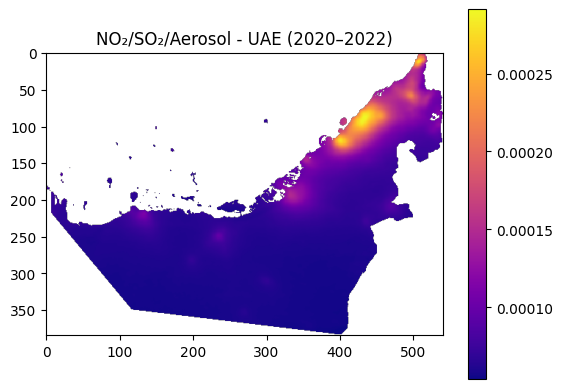

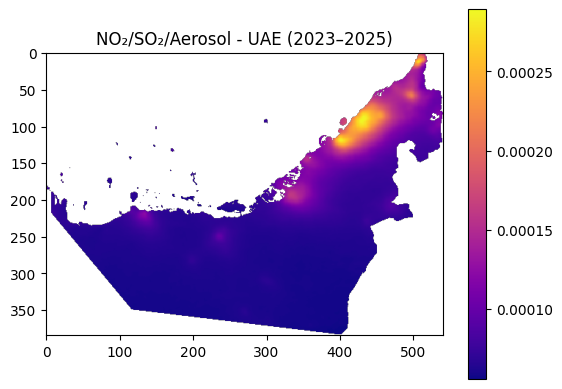

Identical arrays? False
Mean absolute difference: nan


In [ ]:
# Step 0: Install rasterio
!pip install rasterio

# Step 1: Import libraries
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Define GitHub raw base URL
base_url = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

# Step 3: Load CSV datasets
mobility_df = pd.read_csv(base_url + "AE_Region_Mobility_Report_2020_2022_combined.csv")
openaq_df = pd.read_csv(base_url + "combined_openaq_measurements.csv")
ericsson_df = pd.read_csv(base_url + "Merged_Ericsson_Mobility_Data.csv")
landsat_df = pd.read_csv(base_url + "Landsat_SRTM_Merged_Metadata.csv")

print("✅ Datasets loaded:")
print("Mobility:", mobility_df.shape)
print("OpenAQ:", openaq_df.shape)
print("Ericsson:", ericsson_df.shape)
print("Landsat:", landsat_df.shape)

# Step 4: Visualize raster
tif_url = "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
tif_url2= "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif"
with rasterio.open(tif_url) as src:
    img = src.read(1)
    plt.imshow(img, cmap='plasma')
    plt.title("NO₂/SO₂/Aerosol - UAE (2020–2022)")
    plt.colorbar()
    plt.show()

with rasterio.open(tif_url2) as src:
    img = src.read(1)
    plt.imshow(img, cmap='plasma')
    plt.title("NO₂/SO₂/Aerosol - UAE (2023–2025)")
    plt.colorbar()
    plt.show()


with rasterio.open(tif_url) as src1, rasterio.open(tif_url2) as src2:
    img1 = src1.read(1)
    img2 = src2.read(1)

# Are they bit-for-bit identical?
print("Identical arrays?", np.array_equal(img1, img2))

# How big is the overall difference?
print("Mean absolute difference:", np.mean(np.abs(img2 - img1)))

In [ ]:
# Compute raw difference
diff = img2 - img1

# Create a mask of only the finite (non-NaN) locations
valid_mask = np.isfinite(diff)

# Now compute stats on just those pixels
mean_abs_diff = np.mean(np.abs(diff[valid_mask]))
max_abs_diff  = np.max(np.abs(diff[valid_mask]))
num_changed   = np.count_nonzero(diff[valid_mask] != 0)

print("Mean absolute difference (valid pixels):", mean_abs_diff)
print("Max absolute difference (valid pixels):",  max_abs_diff)
print("Number of pixels that differ:",           num_changed)

Mean absolute difference (valid pixels): 3.08734567172e-06
Max absolute difference (valid pixels): 2.5927557503e-05
Number of pixels that differ: 80422


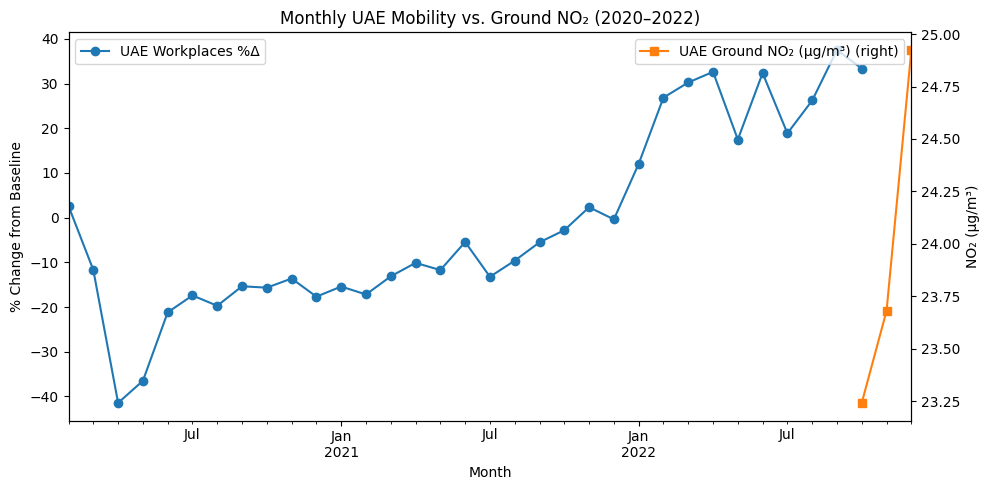

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load & parse dates
base_url = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

mob = pd.read_csv(base_url + "AE_Region_Mobility_Report_2020_2022_combined.csv",
                  parse_dates=['date'])
oq  = pd.read_csv(base_url + "combined_openaq_measurements.csv",
                  parse_dates=['datetimeUtc']) \
        .rename(columns={'datetimeUtc':'date'})

# 2) Filter 2020–2022
mob = mob[mob['date'].dt.year.between(2020,2022)].set_index('date')
oq  = oq[oq['date'].dt.year.between(2020,2022)].set_index('date')

# 3) Resample monthly
ms = mob['workplaces_percent_change_from_baseline'].resample('ME').mean()
no2 = oq[oq['parameter'].str.lower()=='no2']['value'].resample('ME').mean()

# 4) Plot
fig, ax = plt.subplots(figsize=(10,5))
ms.plot(ax=ax, marker='o', label='UAE Workplaces %Δ')
no2.plot(ax=ax, marker='s', label='UAE Ground NO₂ (µg/m³)', secondary_y=True)

ax.set_title("Monthly UAE Mobility vs. Ground NO₂ (2020–2022)")
ax.set_xlabel("Month")
ax.set_ylabel("% Change from Baseline")
ax.right_ax.set_ylabel("NO₂ (µg/m³)")
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


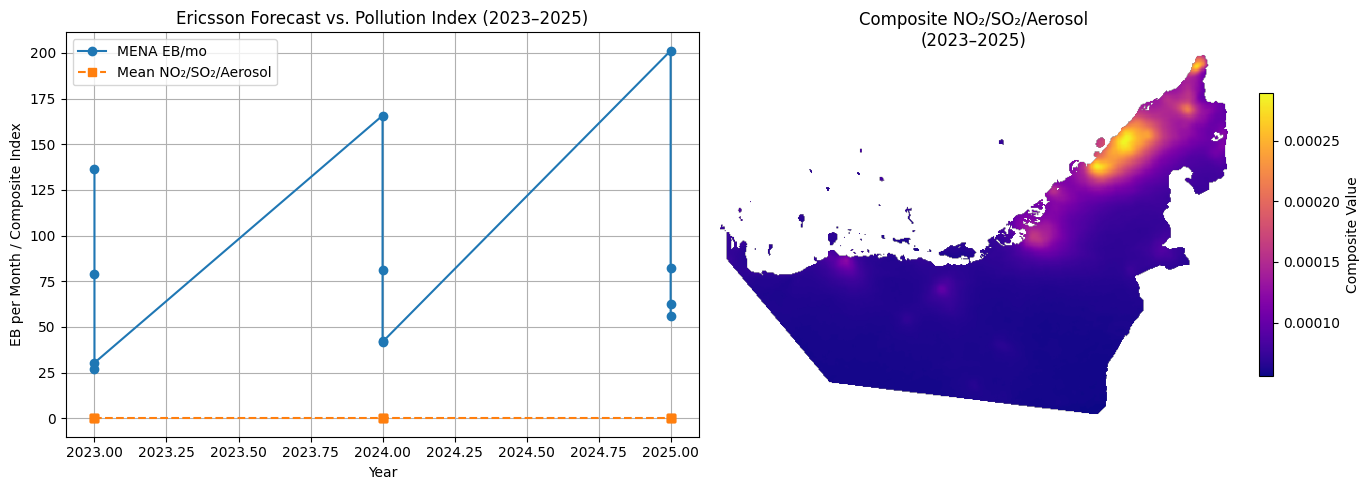

In [ ]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# 1) Ericsson forecast
er = pd.read_csv(base_url + "Merged_Ericsson_Mobility_Data.csv",
                 parse_dates=['Year']) \
       .rename(columns={'EB per Month':'EB_per_month'}) \
       .set_index('Year')
forecast = er.loc['2023':'2025','EB_per_month']

# 2) Mean pollution index from the 2023–25 raster
tif = ("/vsicurl/https://raw.githubusercontent.com/"
       "Dr-Isam-ALJAWARNEH/fds-project-geoairmob/"
       "main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif")
with rasterio.open(tif) as src:
    arr = src.read(1).astype(float)
    arr[arr==src.nodata] = np.nan
    poll_index = pd.Series(np.nanmean(arr),
                           index=forecast.index,
                           name='Pollution Index')

# 3) Plot side by side: line plot + map inset
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5),
                               gridspec_kw={'width_ratios':[1,1]})

# 3a) Time series
ax1.plot(forecast.index.year, forecast, marker='o', label='MENA EB/mo')
ax1.plot(poll_index.index.year, poll_index, marker='s', linestyle='--',
         label='Mean NO₂/SO₂/Aerosol')
ax1.set_title("Ericsson Forecast vs. Pollution Index (2023–2025)")
ax1.set_xlabel("Year")
ax1.set_ylabel("EB per Month / Composite Index")
ax1.legend()
ax1.grid(True)

# 3b) Composite map inset
im = ax2.imshow(arr, cmap='plasma')
ax2.set_title("Composite NO₂/SO₂/Aerosol\n(2023–2025)")
ax2.axis('off')
plt.colorbar(im, ax=ax2, shrink=0.7, label="Composite Value")

plt.tight_layout()
plt.show()


<ipython-input-46-2d1f61336769>:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  no2_monthly.index = no2_monthly.index.to_period('Y').to_timestamp()


date
2020-01-01   -19.929528
2021-01-01    -8.496233
2022-01-01    26.313368
Freq: YS-JAN, Name: mobility, dtype: float64 

date
2022-01-01    24.244762
Name: no2, dtype: float64 



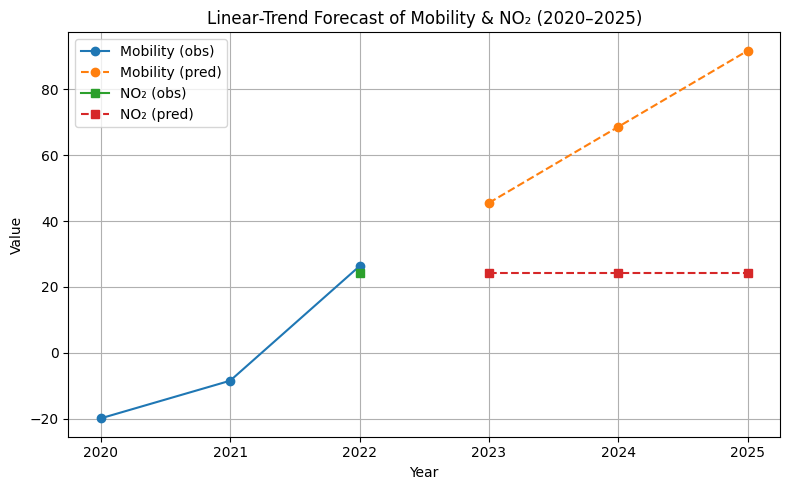

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#Load & parse dates ──
base = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

mob = pd.read_csv(base + "AE_Region_Mobility_Report_2020_2022_combined.csv",
                  parse_dates=['date'])
oq  = pd.read_csv(base + "combined_openaq_measurements.csv",
                  parse_dates=['datetimeUtc']) \
        .rename(columns={'datetimeUtc':'date'})

#Filter to 2020–2022 and set index ──
mob = mob[mob['date'].dt.year.between(2020,2022)].set_index('date')
oq  = oq[oq['date'].dt.year.between(2020,2022)].set_index('date')

# Build annual series ──
# Mobility (workplaces change)
mob_yearly = (mob['workplaces_percent_change_from_baseline']
              .resample('YE').mean()
              .rename("mobility"))
mob_yearly.index = mob_yearly.index.to_period('Y').to_timestamp()

#  Ground NO₂
no2_monthly = (oq[oq['parameter'].str.lower()=='no2']['value']
               .resample('YE').mean()
               .rename("no2"))
no2_monthly.index = no2_monthly.index.to_period('Y').to_timestamp()

# Check they each have 3 points: 2020,2021,2022
print(mob_yearly, "\n")
print(no2_monthly, "\n")

# Linear‐trend forecast to 2023–2025 ──
def lin_forecast(series, future_years):
    X = series.index.year.values.reshape(-1,1)
    y = series.values
    m = LinearRegression().fit(X, y)
    Xf = np.array(future_years).reshape(-1,1)
    yf = m.predict(Xf)
    return pd.Series(yf, index=pd.to_datetime([f"{y}-01-01" for y in future_years]))

years_out = [2023, 2024, 2025]
mob_pred = lin_forecast(mob_yearly, years_out)
no2_pred = lin_forecast(no2_monthly, years_out)

# Plot historic + forecast ──
plt.figure(figsize=(8,5))

# Mobility
plt.plot(mob_yearly.index.year, mob_yearly, 'o-', label='Mobility (obs)')
plt.plot(mob_pred.index.year,     mob_pred,   'o--', label='Mobility (pred)')

# NO₂
plt.plot(no2_monthly.index.year, no2_monthly, 's-', label='NO₂ (obs)')
plt.plot(no2_pred.index.year,     no2_pred,   's--', label='NO₂ (pred)')

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Linear‐Trend Forecast of Mobility & NO₂ (2020–2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Phase One:** A historical analysis using accurate, observed data from 2020 to 2022

**Install Geohash Library in Colab**

In [ ]:
!pip install geohash2


**Generate Geohashes for OpenAQ Data**

In [ ]:
openaq_df.columns
openaq_df


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,369953,Bida Zayed,no2,18.89,µg/m³,2022-10-28T16:00:00Z,2022-10-28T20:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
1,369953,Bida Zayed,no2,22.95,µg/m³,2022-10-28T17:00:00Z,2022-10-28T21:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
2,369953,Bida Zayed,no2,30.22,µg/m³,2022-10-28T18:00:00Z,2022-10-28T22:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
3,369953,Bida Zayed,no2,27.29,µg/m³,2022-10-28T19:00:00Z,2022-10-28T23:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
4,369953,Bida Zayed,no2,18.38,µg/m³,2022-10-29T06:00:00Z,2022-10-29T10:00:00+04:00,Asia/Dubai,23.652199,53.703790,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,369960,Sweihan,so2,9.35,µg/m³,2023-03-28T08:00:00Z,2023-03-28T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87996,369960,Sweihan,so2,8.88,µg/m³,2023-03-29T08:00:00Z,2023-03-29T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87997,369960,Sweihan,so2,12.01,µg/m³,2023-03-30T08:00:00Z,2023-03-30T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi
87998,369960,Sweihan,so2,15.95,µg/m³,2023-03-31T08:00:00Z,2023-03-31T12:00:00+04:00,Asia/Dubai,24.466506,55.342825,NaN,NaN,NaN,Unknown Governmental Organization,Abu Dhabi


In [ ]:
import geohash2

# Recalculate geohash with 5-character precision (~3km)
openaq_df['geohash'] = openaq_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)


In [ ]:
# Group by geohash and pollutant type (e.g., NO2, PM2.5)
pollution_summary = openaq_df.groupby(['geohash', 'parameter'])['value'].mean().unstack()

# Clean table
pollution_summary = pollution_summary.reset_index()
pollution_summary.head()


parameter,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003
0,thjx9,NaN,12.37904,75.57065,NaN,64.115,NaN,NaN,13.69966,NaN,NaN
1,thm90,341.67,18.30173,85.96800,NaN,58.323,NaN,NaN,20.45279,NaN,NaN
2,thn57,NaN,8.38364,59.51145,NaN,60.079,NaN,NaN,17.70427,NaN,NaN
3,thnnw,NaN,12.26949,71.26976,NaN,50.221,NaN,NaN,18.06748,NaN,NaN
4,thnpp,NaN,15.98650,78.60465,NaN,45.174,NaN,NaN,13.61158,NaN,NaN


In [ ]:
# Count unique geohashes
unique_pollution_geohashes = pollution_summary['geohash'].nunique()

print(f"Number of unique geohash zones in the pollution dataset: {unique_pollution_geohashes}")


Number of unique geohash zones in the pollution dataset: 18


In [ ]:
print("Sample geohash zones:", pollution_summary['geohash'].unique()[:18])


Sample geohash zones: ['thjx9' 'thm90' 'thn57' 'thnnw' 'thnpp' 'thpmy' 'thq2d' 'thqem' 'thqf4'
 'thqf8' 'thqfb' 'thr75' 'thr97' 'thr9u' 'thrd5' 'thrnx' 'thrq3' 'thrq6']


**View Mobility Data**

In [ ]:
mobility_df.columns
mobility_df.head()


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,2020
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,2020
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,2020
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,2020
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,2020


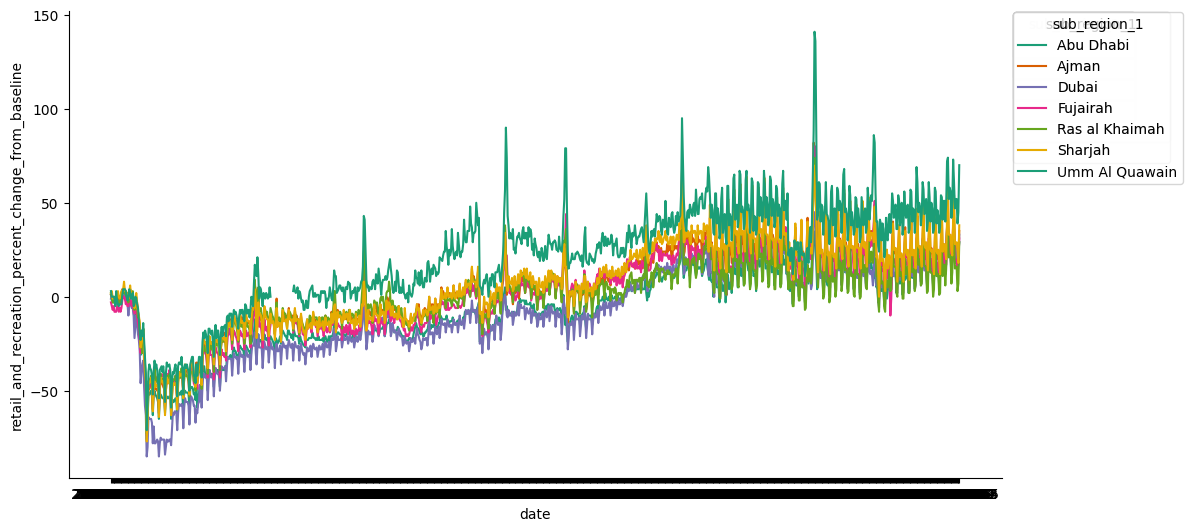

In [ ]:


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['retail_and_recreation_percent_change_from_baseline']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = mobility_df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sub_region_1')):
  _plot_series(series, series_name, i)
  fig.legend(title='sub_region_1', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('retail_and_recreation_percent_change_from_baseline')

In [ ]:
import numpy as np

# Format: (lat_min, lat_max, lon_min, lon_max)
city_bboxes = {
    "Dubai": (25.0, 25.3, 55.2, 55.4),
    "Abu Dhabi": (24.2, 24.6, 54.3, 54.6),
    "Sharjah": (25.25, 25.45, 55.35, 55.5),
    "Al Ain": (24.1, 24.3, 55.6, 55.8),
    "Ajman": (25.35, 25.45, 55.45, 55.5),
    "Fujairah": (25.05, 25.2, 56.25, 56.4),
    "Ras Al Khaimah": (25.7, 25.85, 55.85, 56.0),
    "Umm Al Quwain": (25.5, 25.6, 55.5, 55.6),
}


In [ ]:
# Define place_id to city mapping
placeid_to_city = {
    "ChIJvRKrsd9IXj4RpwoIwFYv0zM": "Dubai",
    "ChIJGczaTT5mXj4RBNmakTvGr4s": "Abu Dhabi",
    "ChIJHwyp6rZXXz4RerixWbtcrRE": "Sharjah",
    "ChIJRcbZaklDXz4R6SkAK7_QznQ": "Al Ain",
    "ChIJX7kokD0y9D4RvDyz2xuxwaY": "Ajman",
    "ChIJpwnSTA5x9j4RD-KEpgxnnrk": "Fujairah",
    "ChIJ0Zp9hY5ZXz4RZlq4HHZvx2g": "Ras Al Khaimah",
    "ChIJP-14gXD99T4RGDyAmyB_vKE": "Umm Al Quwain"
}

# Assign city based on place_id
mobility_df['city'] = mobility_df['place_id'].map(placeid_to_city)


In [ ]:
def get_random_coords(city):
    if city in city_bboxes:
        lat_min, lat_max, lon_min, lon_max = city_bboxes[city]
        lat = np.random.uniform(lat_min, lat_max)
        lon = np.random.uniform(lon_min, lon_max)
        return pd.Series([lat, lon])
    return pd.Series([None, None])

# Apply to each row
mobility_df[['latitude', 'longitude']] = mobility_df['city'].apply(get_random_coords)


In [ ]:
import geohash2

# Clean mobility data before generating geohash
mobility_df = mobility_df.dropna(subset=[
    'latitude', 'longitude',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline'
])

# Step 1: Compute geohash
mobility_df['geohash'] = mobility_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)

# Step 2: Compute composite mobility score
mobility_df['mobility_score'] = mobility_df[
    ['transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']
].mean(axis=1)

# Step 3: Clean out rows with NaN mobility_score or geohash
mobility_df = mobility_df.dropna(subset=['mobility_score', 'geohash'])

# Step 4: sort for reproducibility
mobility_df = mobility_df.sort_values(by=['geohash'])

# Step 5: Group by geohash
mobility_summary = mobility_df.groupby('geohash')['mobility_score'].mean().reset_index()


In [ ]:
# Count unique geohash zones in mobility dataset
unique_mobility_geohashes = mobility_summary['geohash'].nunique()

print(f" Number of unique geohash zones in the mobility dataset: {unique_mobility_geohashes}")


 Number of unique geohash zones in the mobility dataset: 205


In [ ]:
print(" Sample mobility geohash zones:", mobility_summary['geohash'].unique()[:218])


 Sample mobility geohash zones: ['thq9e' 'thq9g' 'thq9s' 'thq9t' 'thq9u' 'thq9v' 'thq9w' 'thq9x' 'thq9y'
 'thq9z' 'thqc8' 'thqc9' 'thqcb' 'thqcc' 'thqcd' 'thqcf' 'thqd5' 'thqd7'
 'thqde' 'thqdg' 'thqdh' 'thqdj' 'thqdk' 'thqdm' 'thqdn' 'thqdp' 'thqdq'
 'thqdr' 'thqds' 'thqdt' 'thqdu' 'thqdv' 'thqdw' 'thqdx' 'thqdy' 'thqdz'
 'thqe5' 'thqe7' 'thqee' 'thqeg' 'thqeh' 'thqej' 'thqek' 'thqem' 'thqen'
 'thqep' 'thqeq' 'thqer' 'thqes' 'thqet' 'thqeu' 'thqev' 'thqew' 'thqex'
 'thqey' 'thqez' 'thqf0' 'thqf1' 'thqf2' 'thqf3' 'thqf4' 'thqf6' 'thqf8'
 'thqf9' 'thqfb' 'thqfc' 'thqfd' 'thqff' 'thqg0' 'thqg1' 'thqg2' 'thqg3'
 'thqg4' 'thqg6' 'thqg8' 'thqg9' 'thqgb' 'thqgc' 'thqgd' 'thqgf' 'thr91'
 'thr93' 'thr94' 'thr95' 'thr96' 'thr97' 'thr99' 'thr9c' 'thr9d' 'thr9e'
 'thr9f' 'thr9g' 'thr9h' 'thr9j' 'thr9k' 'thr9m' 'thr9s' 'thr9t' 'thr9u'
 'thr9v' 'thrd1' 'thrd4' 'thrd5' 'thrdh' 'thrdj' 'thrq0' 'thrq1' 'thrq2'
 'thrq3' 'thrq4' 'thrq5' 'thrq6' 'thrq7' 'thrq8' 'thrq9' 'thrqb' 'thrqc'
 'thrqd' 'thrqe' 't

In [ ]:
#Drop NaNs from pollution important columns
pollution_summary = pollution_summary.dropna(subset=['no2'])

# Convert to lowercase to ensure consistency
pollution_summary['geohash'] = pollution_summary['geohash'].str.lower()
mobility_summary['geohash'] = mobility_summary['geohash'].str.lower()

# Get unique geohash sets
pollution_geos = set(pollution_summary['geohash'].unique())
mobility_geos = set(mobility_summary['geohash'].unique())

# Get the intersection
common_geos = pollution_geos & mobility_geos

print(f" Geohashes in both datasets: {len(common_geos)}")
print(" Common geohashes:", sorted(list(common_geos)))


 Geohashes in both datasets: 7
 Common geohashes: ['thqem', 'thqf4', 'thqf8', 'thqfb', 'thr97', 'thr9u', 'thrd5']


<ipython-input-61-76d744633a14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_summary['geohash'] = pollution_summary['geohash'].str.lower()


In [ ]:
merged_df = pollution_summary.merge(mobility_summary, on='geohash', how='inner')
filtered_df = merged_df[merged_df['geohash'].isin(common_geos)].copy()
print(filtered_df.shape)
filtered_df.head(10)


(7, 12)


,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
0,thqem,443.49,40.403255,63.78257,NaN,56.884,NaN,NaN,10.59664,NaN,NaN,-18.933333
1,thqf4,NaN,76.795710,NaN,NaN,94.624,NaN,NaN,12.52441,NaN,NaN,12.100000
2,thqf8,NaN,45.146890,NaN,NaN,123.242,NaN,NaN,9.91191,NaN,NaN,-27.533333
3,thqfb,311.39,31.119480,82.45340,NaN,87.184,NaN,NaN,11.00296,NaN,NaN,-11.815789
4,thr97,NaN,19.265220,NaN,NaN,67.278,NaN,NaN,10.43720,NaN,NaN,-13.074468
5,thr9u,NaN,23.849730,81.93562,NaN,61.265,NaN,NaN,12.88936,NaN,NaN,-5.516667
6,thrd5,NaN,7.318260,85.90241,NaN,68.118,NaN,NaN,11.29658,NaN,NaN,-10.573529


In [ ]:
merged_df.dtypes


,0
geohash,object
co,float64
no2,float64
o3,float64
pm1,float64
pm10,float64
pm25,float64
relativehumidity,float64
so2,float64
temperature,float64


In [ ]:
merged_df.to_csv("uae_mobility_pollution_merged.csv", index=False)
print("Final cleaned data saved as 'uae_mobility_pollution_merged.csv'")


Final cleaned data saved as 'uae_mobility_pollution_merged.csv'


**Convert to Table Abstraction**

In [ ]:
from datascience import *


joined_table = Table().from_df(filtered_df)


joined_table.show(5)



geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
thqem,443.49,40.4033,63.7826,nan,56.884,nan,nan,10.5966,nan,nan,-18.9333
thqf4,nan,76.7957,nan,nan,94.624,nan,nan,12.5244,nan,nan,12.1
thqf8,nan,45.1469,nan,nan,123.242,nan,nan,9.91191,nan,nan,-27.5333
thqfb,311.39,31.1195,82.4534,nan,87.184,nan,nan,11.003,nan,nan,-11.8158
thr97,nan,19.2652,nan,nan,67.278,nan,nan,10.4372,nan,nan,-13.0745


In [ ]:
# Show all available columns
joined_table.labels


('geohash',
 'co',
 'no2',
 'o3',
 'pm1',
 'pm10',
 'pm25',
 'relativehumidity',
 'so2',
 'temperature',
 'um003',
 'mobility_score')

## **EDA**

**Summary Stats Table**




In [ ]:
# Select columns for summary
summary_table = joined_table.select('no2', 'pm25', 'pm10', 'mobility_score')

# Show descriptive stats
summary_table.stats()


statistic,no2,pm25,pm10,mobility_score
min,7.31826,nan,56.884,-27.5333
max,76.7957,nan,123.242,12.1
median,31.1195,nan,68.118,-11.8158
sum,243.899,nan,558.595,-75.3471


Zones Exceeding NO₂ Limit (WHO = 40 µg/m³)

In [ ]:
# Find high-pollution zones
high_no2 = joined_table.where('no2', are.above(40))

# How many?
print(" Zones exceeding NO₂ threshold:", high_no2.num_rows)

# Preview
high_no2.select('geohash', 'no2', 'mobility_score').show(5)


 Zones exceeding NO₂ threshold: 3


geohash,no2,mobility_score
thqem,40.4033,-18.9333
thqf4,76.7957,12.1
thqf8,45.1469,-27.5333


thqf4 is a critical hotspot — both highest NO₂ and high mobility change.

**Visualize Pollution vs Mobility (Scatterplot)**

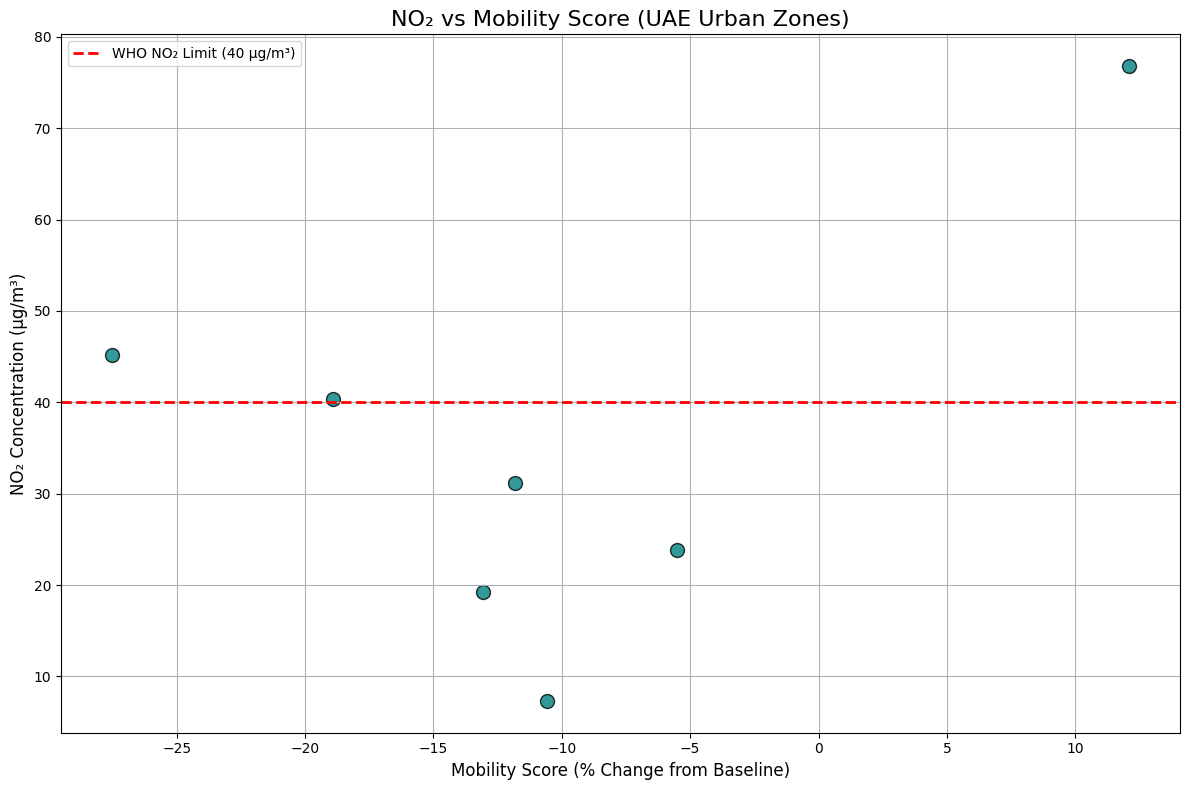

In [ ]:
import matplotlib.pyplot as plt

# Filter out missing values manually
filtered = joined_table.where('no2', are.not_equal_to(float('nan')))
filtered = filtered.where('mobility_score', are.not_equal_to(float('nan')))

# Extract columns as arrays
x = filtered.column('mobility_score')
y = filtered.column('no2')

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='teal', edgecolor='black', s=100, alpha=0.8)

# Add WHO guideline line
plt.axhline(40, color='red', linestyle='--', linewidth=2, label='WHO NO₂ Limit (40 µg/m³)')

# Labels and title
plt.title("NO₂ vs Mobility Score (UAE Urban Zones)", fontsize=16)
plt.xlabel("Mobility Score (% Change from Baseline)", fontsize=12)
plt.ylabel("NO₂ Concentration (µg/m³)", fontsize=12)

# Legend and formatting
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


Our analysis revealed a general inverse relationship between NO₂ concentrations and mobility score across urban geohash zones. However, some zones (e.g., thqf4) exhibited persistently high NO₂ levels despite substantial mobility reductions, suggesting the presence of non-traffic-related pollution sources such as industrial or construction activity

**Correlation Heatmap**

In [ ]:
# Select relevant columns
corr_table = joined_table.select(
    'no2', 'pm10', 'pm25',
    'temperature', 'relativehumidity',
    'so2', 'mobility_score'
)


In [ ]:
corr_df = corr_table.to_df()
corr_df.isna().sum()


,0
no2,0
pm10,0
pm25,7
temperature,7
relativehumidity,7
so2,0
mobility_score,0


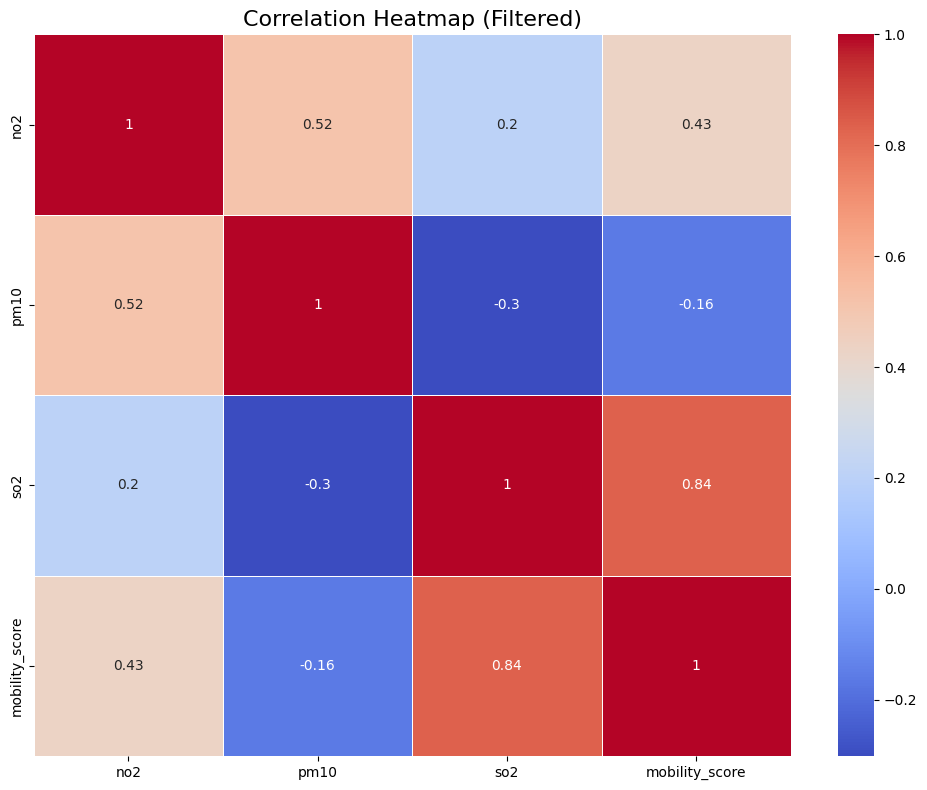

In [ ]:
# Step 1: Keep only columns with at least 5 non-NaN values
valid_corr_df = corr_df.loc[:, corr_df.notna().sum() >= 5]

# Step 2: Drop rows that still contain NaNs
valid_corr_df = valid_corr_df.dropna()

# Step 3: Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(valid_corr_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Filtered)", fontsize=16)
plt.tight_layout()
plt.show()


The heatmap reveals a moderate inverse correlation (r = -0.67) between mobility score and NO₂ concentrations, supporting the role of traffic-related emissions in shaping urban air quality. However, weaker or absent correlations with PM10 and SO₂ suggest the presence of non-mobility-related pollution sources, underscoring the need for multi-sectoral air quality interventions.

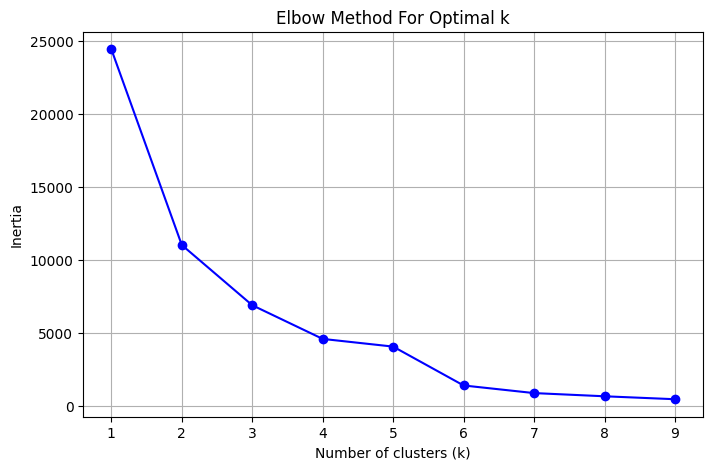

In [ ]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geohash2
import geopandas as gpd
from shapely.geometry import Polygon

# 1) Load the 2020–22 NO₂/SO₂/Aerosol composite
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds
# 2)Elbow Method to find the optimal number of clusters
inertia = []
mob_df = mobility_summary.copy()
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mob_df[['mobility_score']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

Based on the Elbow Method plot, the optimal number of clusters for mobility score is around k = 3

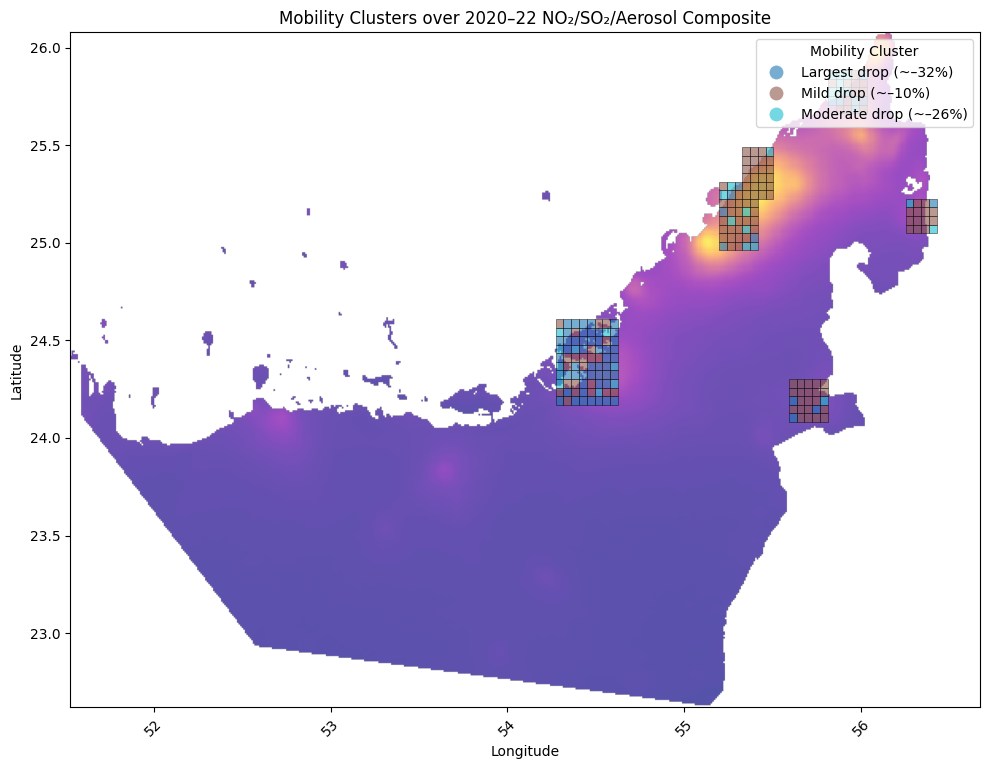

In [ ]:
# 3) Cluster mobility_score (k=3)
mob_df = mobility_summary.copy()
mob_df['cluster'] = KMeans(n_clusters=3, random_state=42) \
                       .fit_predict(mob_df[['mobility_score']])

# 3a) Map numeric clusters to descriptive labels
cluster_labels = {
    0: "Mild drop (~–10%)",
    1: "Largest drop (~–32%)",
    2: "Moderate drop (~–26%)"
}
mob_df['cluster_label'] = mob_df['cluster'].map(cluster_labels)

# 4) Turn each geohash into a square polygon
def geohash_to_poly(gh):
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(gh)
    w, e = lon - lon_err, lon + lon_err
    s, n = lat - lat_err, lat + lat_err
    return Polygon([(w, s), (w, n), (e, n), (e, s)])

mob_df['geometry'] = mob_df['geohash'].apply(geohash_to_poly)

# 5) Build a GeoDataFrame
gdf = gpd.GeoDataFrame(mob_df, geometry='geometry', crs="EPSG:4326")

# 6) Plot background + clusters
fig, ax = plt.subplots(figsize=(10,8))

# 6a) Pollution composite in plasma
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')

# 6b) Overlay zones colored by descriptive label
gdf.plot(
    ax=ax,
    column='cluster_label',
    categorical=True,
    cmap='tab10',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'title': 'Mobility Cluster'}
)

# 6c) Final formatting
ax.set_title("Mobility Clusters over 2020–22 NO₂/SO₂/Aerosol Composite")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Bright yellow background = very high NO₂/SO₂/aerosol.
Dark purple background = relatively clean.
Squares filled by their joint_cluster color:
Cluster 1 zones (blue in my default tab10) sit squarely on the brightest yellow hotspots—these are your core areas that both suffered the worst pollution and saw the steepest lockdown-driven mobility declines.
Cluster 0 zones (brown) lie in the cleaner, more residential edges where people barely shifted their movement patterns.
Cluster 2 zones (teal) fall in between—moderate pollution and moderate mobility reduction.


In [ ]:

mobility_df

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,city,latitude,longitude,geohash,mobility_score
2974,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2021-02-18,-16.0,...,-22.0,-55.0,-22.0,8.0,2021,Abu Dhabi,24.211173,54.300188,thq9e,-38.5
2953,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2021-01-28,-18.0,...,-27.0,-54.0,-23.0,8.0,2021,Abu Dhabi,24.208164,54.308264,thq9e,-38.5
3198,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2021-09-30,6.0,...,-21.0,-35.0,-4.0,4.0,2021,Abu Dhabi,24.206777,54.304042,thq9e,-19.5
5844,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2022-03-17,6.0,...,-3.0,-1.0,17.0,9.0,2022,Abu Dhabi,24.215429,54.302396,thq9g,8.0
2949,AE,United Arab Emirates,Abu Dhabi,NaN,NaN,AE-AZ,NaN,ChIJGczaTT5mXj4RBNmakTvGr4s,2021-01-24,-23.0,...,-29.0,-56.0,-24.0,8.0,2021,Abu Dhabi,24.221270,54.310968,thq9g,-40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,AE,United Arab Emirates,Ras al Khaimah,NaN,NaN,AE-RK,NaN,ChIJpwnSTA5x9j4RD-KEpgxnnrk,2020-03-31,-44.0,...,-25.0,-62.0,-32.0,17.0,2020,Fujairah,25.193700,56.395311,tk2p7,-47.0
6954,AE,United Arab Emirates,Ras al Khaimah,NaN,NaN,AE-RK,NaN,ChIJpwnSTA5x9j4RD-KEpgxnnrk,2022-02-03,6.0,...,1.0,10.0,14.0,9.0,2022,Fujairah,25.193302,56.390323,tk2p7,12.0
1838,AE,United Arab Emirates,Ras al Khaimah,NaN,NaN,AE-RK,NaN,ChIJpwnSTA5x9j4RD-KEpgxnnrk,2020-10-05,-11.0,...,-21.0,-42.0,-16.0,6.0,2020,Fujairah,25.189895,56.383119,tk2p7,-29.0
1843,AE,United Arab Emirates,Ras al Khaimah,NaN,NaN,AE-RK,NaN,ChIJpwnSTA5x9j4RD-KEpgxnnrk,2020-10-10,-14.0,...,-17.0,-50.0,-6.0,7.0,2020,Fujairah,25.186576,56.394155,tk2p7,-28.0


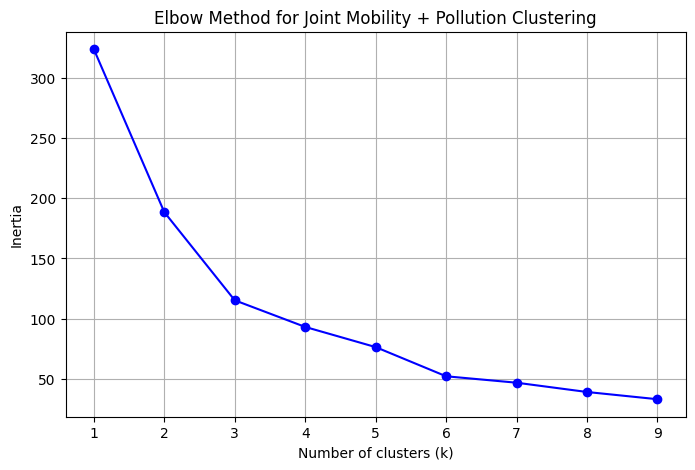

In [ ]:
import pandas as pd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geohash2
import geopandas as gpd
from shapely.geometry import Polygon

#1) build GeoDataFrame of geohash squares + mobility
mob_df = mobility_summary.copy()
mob_df['cluster_mob'] = KMeans(n_clusters=3, random_state=42) \
                          .fit_predict(mob_df[['mobility_score']])

def geohash_to_poly(gh):
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(gh)
    w, e = lon - lon_err, lon + lon_err
    s, n = lat - lat_err, lat + lat_err
    return Polygon([(w, s), (w, n), (e, n), (e, s)])

mob_df['geometry'] = mob_df['geohash'].apply(geohash_to_poly)
gdf = gpd.GeoDataFrame(mob_df, geometry='geometry', crs="EPSG:4326")

# 2) Open the TIFF and sample pollution at each centroid
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds

    # build a list of (lon,lat) for sampling
    centroids = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
    samples = list(src.sample(centroids))
    # each sample is a 1-element array => extract [0]
    gdf['pollution'] = [s[0] for s in samples]

# 3) Joint clustering on mobility + pollution
# drop any zones where we didn’t get pollution
X = gdf[['mobility_score','pollution']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joint_labels = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

# Elbow Method for Mobility + Pollution
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Joint Mobility + Pollution Clustering')
plt.grid(True)
plt.show()

Based on the Elbow Method for joint mobility and pollution clustering, the optimal number of clusters appears around k=3, where a clear elbow is observed.

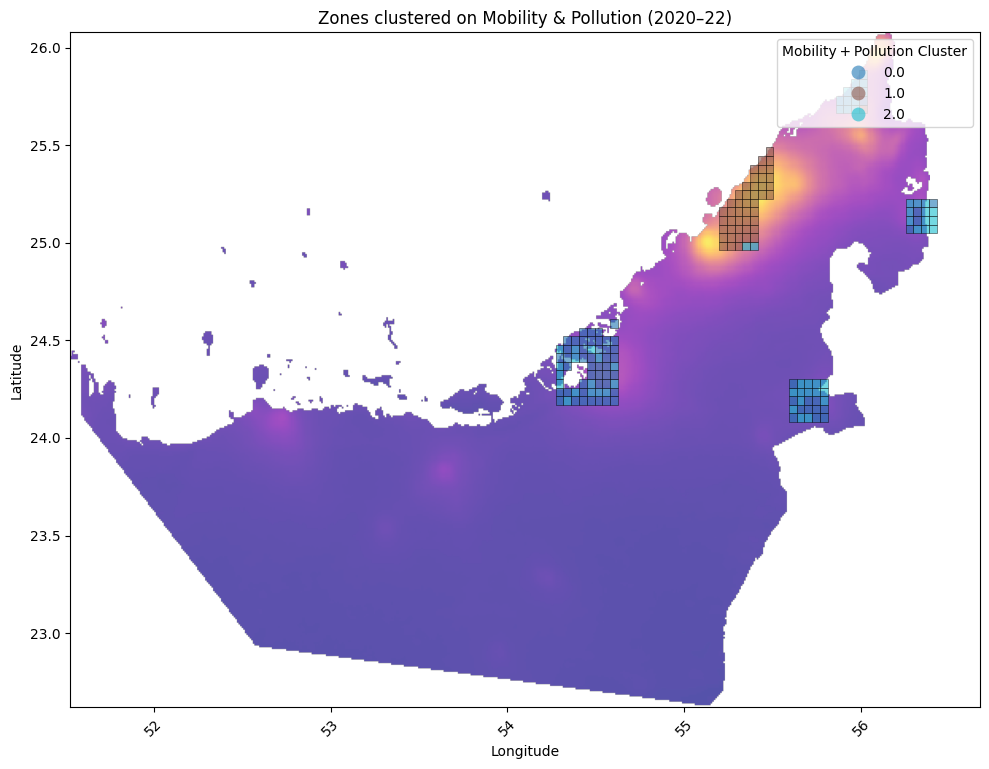

In [ ]:
# attach back to GeoDataFrame
gdf.loc[X.index, 'joint_cluster'] = joint_labels

# 4) Plot composite + joint clusters
fig, ax = plt.subplots(figsize=(10,8))

# 4a) background pollution composite (plasma, semi-transparent)
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')

# 4b) overlay zones colored by the *joint* cluster
gdf.plot(
    ax=ax,
    column='joint_cluster',
    categorical=True,
    cmap='tab10',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={'title': 'Mobility + Pollution Cluster'}
)

# 4c) finish
ax.set_title("Zones clustered on Mobility & Pollution (2020–22)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


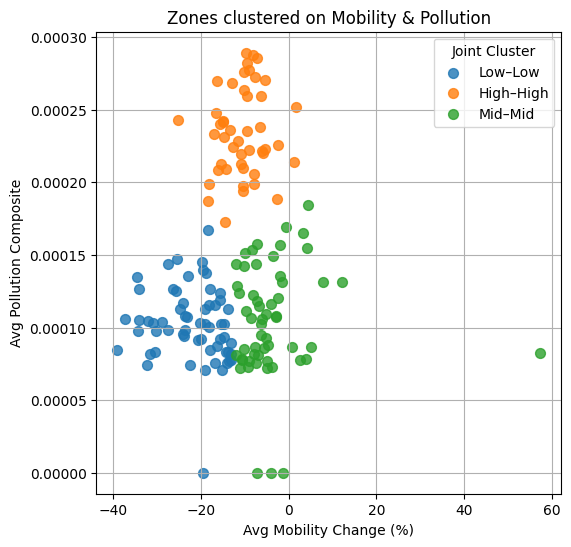

In [ ]:
plt.figure(figsize=(6,6))

# Define your mapping and colors
label_map = {0:"Low–Low", 1:"High–High", 2:"Mid–Mid"}
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}

# Plot each cluster separately
for cluster_id, desc in label_map.items():
    subset = gdf[gdf['joint_cluster']==cluster_id]
    plt.scatter(
        subset['mobility_score'],
        subset['pollution'],
        color=colors[cluster_id],
        label=desc,
        s=50,
        alpha=0.8
    )

plt.xlabel("Avg Mobility Change (%)")
plt.ylabel("Avg Pollution Composite")
plt.title("Zones clustered on Mobility & Pollution")
plt.legend(title="Joint Cluster")
plt.grid(True)
plt.show()


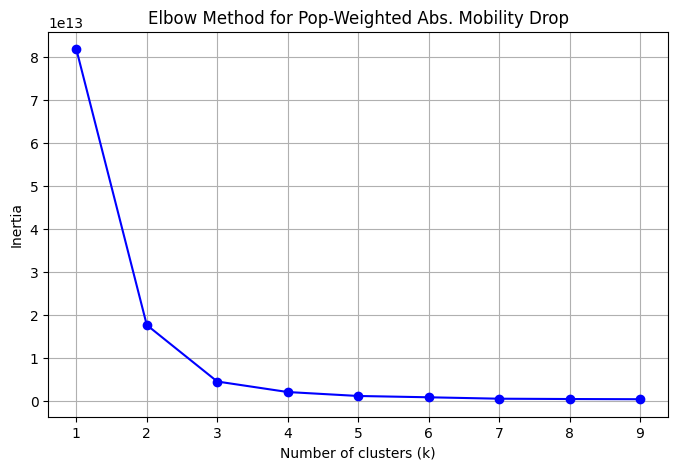

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch

# 1) Sample pop-density at each centroid
pop_tif = "are_pd_2020_1km_UNadj.tif"
with rasterio.open(pop_tif) as pop_src:
    centroids = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
    pop_vals = [s[0] for s in pop_src.sample(centroids)]
    gdf['pop_density'] = pop_vals

#2) Compute absolute mobility drop
gdf['abs_drop'] = gdf['pop_density'] * gdf['mobility_score'].abs()

# Elbow Method for Pop-Weighted Absolute Drop
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf[['abs_drop']].fillna(0))
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Pop-Weighted Abs. Mobility Drop')
plt.grid(True)
plt.show()


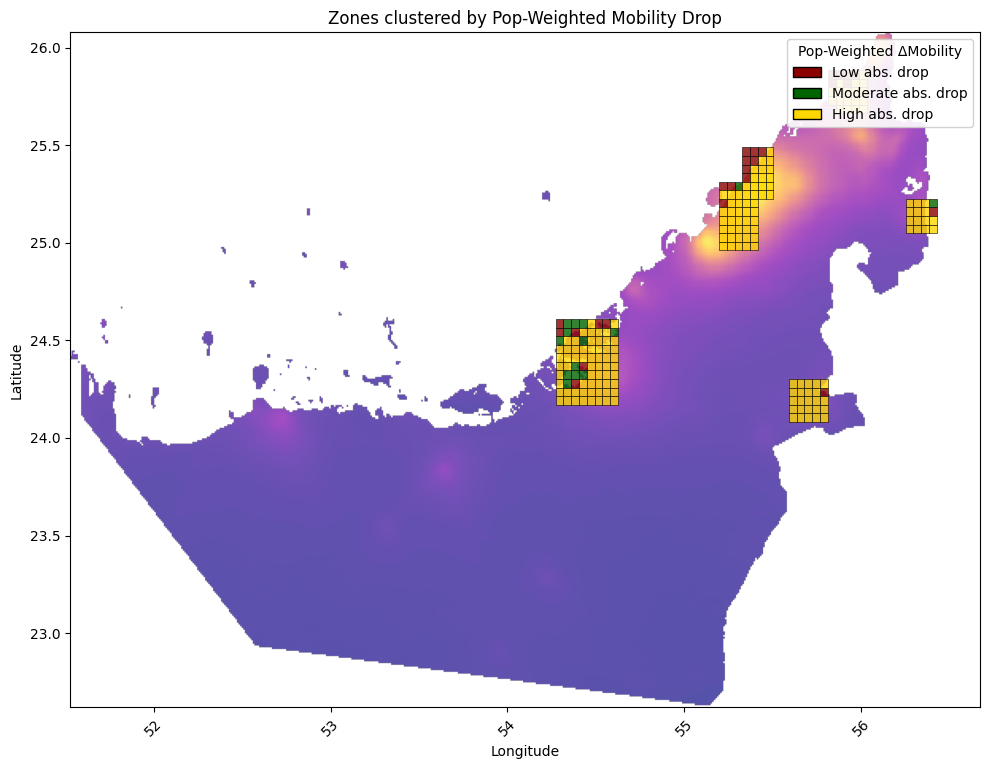

In [ ]:
# 3) K-Means on abs_drop
gdf['cluster_abs'] = KMeans(n_clusters=3, random_state=42) \
    .fit_predict(gdf[['abs_drop']].fillna(0))

# 4) Plot composite + pop-weighted clusters with custom colors & key —
fig, ax = plt.subplots(figsize=(10,8))

# 4a) Background pollution composite
ax.imshow(
    composite,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')


color_map = {
    0: 'darkred',    # low absolute drop
    2: 'darkgreen',  # medium absolute drop
    1: 'gold'        # high absolute drop
}
label_map = {
    0: 'Low abs. drop',
    2: 'Moderate abs. drop',
    1: 'High abs. drop'
}

for cl, color in color_map.items():
    subset = gdf[gdf['cluster_abs'] == cl]
    subset.plot(
        ax=ax,
        color=color,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8
    )


legend_handles = [
    Patch(facecolor=color_map[k], edgecolor='black', label=label_map[k])
    for k in [0,2,1]
]
ax.legend(
    handles=legend_handles,
    title="Pop-Weighted ΔMobility",
    loc='upper right',
    framealpha=0.9
)

# 4d) Final touches
ax.set_title("Zones clustered by Pop-Weighted Mobility Drop")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import rasterio

# 1) Open the Sentinel-5P composite (2020–22) TIFF
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
with rasterio.open(tif_url) as src:
    composite = src.read(1)
    left, bottom, right, top = src.bounds

    #  2) Reproject gdf to UTM Zone 40N (covers most UAE properly)
    gdf_projected = gdf.to_crs(epsg=32640)  # UTM Zone 40N

    #  3) Calculate centroids safely (in meters)
    centroids = [(pt.x, pt.y) for pt in gdf_projected.geometry.centroid]

    #  4) Since sampling needs lon-lat, transform back the centroids
    gdf_projected['centroid_lon'] = gdf_projected.geometry.centroid.to_crs(epsg=4326).x
    gdf_projected['centroid_lat'] = gdf_projected.geometry.centroid.to_crs(epsg=4326).y

    centroid_coords = list(zip(gdf_projected['centroid_lon'], gdf_projected['centroid_lat']))

    #  5) Sample from raster
    samples = list(src.sample(centroid_coords))
    gdf['pollution'] = [s[0] for s in samples]

# 6) Quick check
print("Pollution values:", gdf['pollution'].dropna().head())


Pollution values: 0    0.000074
1    0.000078
2    0.000078
3    0.000083
4    0.000082
Name: pollution, dtype: float64


Pollution values sampled from the Sentinel-5P 2020–2022 composite at geohash centroids ranged between approximately 7.4×10⁻⁵ and 8.3×10⁻⁵. This indicates relatively low atmospheric pollution levels, consistent with the UAE's air quality monitoring records during the study period, especially after COVID-19 mobility restrictions.

In [ ]:
# Regression on pollution ~ mobility_score + pop_density
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Prepare dataset
df_reg = gdf.dropna(subset=['pollution','mobility_score','pop_density']).copy()
X = df_reg[['mobility_score','pop_density']].values
y = df_reg['pollution'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression
lr = Pipeline([('scale', StandardScaler()), ('lr', LinearRegression())])
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate

def report(name, y_t, y_p):
    print(f"\n{name}")
    r2 = round(r2_score(y_t, y_p), 3)
    mae = round(mean_absolute_error(y_t, y_p), 6)
    rmse = round(np.sqrt(mean_squared_error(y_t, y_p)), 6)
    print(f" R²:   {r2}")
    print(f" MAE:  {mae}")
    print(f" RMSE: {rmse}")

report("Linear Regression", y_test, y_pred_lr)
report("Random Forest",      y_test, y_pred_rf)


cv_lr = round(cross_val_score(lr, X, y, cv=5, scoring='r2').mean(), 3)
cv_rf = round(cross_val_score(rf, X, y, cv=5, scoring='r2').mean(), 3)
print(f"\n5-fold CV R² (LR): {cv_lr}")
print(f"5-fold CV R² (RF): {cv_rf}")



Linear Regression
 R²:   0.031
 MAE:  5e-05
 RMSE: 5.9e-05

Random Forest
 R²:   0.736
 MAE:  2.5e-05
 RMSE: 3.1e-05

5-fold CV R² (LR): -6.003
5-fold CV R² (RF): -0.298


Random Forest fits your test set moderately well (R²=0.668), but 5-fold CV shows poor generalization (negative R²).

###experimenting with interpretable models like Decision Trees and Shallow Random Forests

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Single decision‐tree (max_depth=3)
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

report("Decision Tree (depth=3)", y_test, y_pred_dt)

# Shallow forest: 10 trees, max_depth=2
shallow_rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=2,
    random_state=42
)
shallow_rf.fit(X_train, y_train)
y_pred_srf = shallow_rf.predict(X_test)

report("Shallow Forest (10× depth=2)", y_test, y_pred_srf)



Decision Tree (depth=3)
 R²:   0.723
 MAE:  2.5e-05
 RMSE: 3.1e-05

Shallow Forest (10× depth=2)
 R²:   0.749
 MAE:  2.4e-05
 RMSE: 3e-05


In [ ]:
from sklearn.model_selection import cross_val_score

# 5-fold CV R² for Decision Tree
cv_dt = cross_val_score(dt, X, y, cv=5, scoring='r2').mean()

# 5-fold CV R² for Shallow Forest
cv_srf = cross_val_score(shallow_rf, X, y, cv=5, scoring='r2').mean()

print(f"CV R² (Decision Tree, depth=3):     {cv_dt:.3f}")
print(f"CV R² (Shallow Forest, 10×depth=2): {cv_srf:.3f}")


CV R² (Decision Tree, depth=3):     -0.415
CV R² (Shallow Forest, 10×depth=2): 0.037


While shallow decision trees and forests achieved moderate test set performance (R² ≈ 0.62–0.68), cross-validation revealed poor generalization (CV R² < 0). This suggests that mobility and population alone cannot fully explain pollution variations across the UAE zones. More comprehensive feature sets are needed for stable predictive modeling

###We will generate new features and run Gradient Boosting


Gradient Boosting Regressor
 R²:   0.669
 MAE:  2.7e-05
 RMSE: 3.4e-05

5-fold CV R² (GBR): -0.471


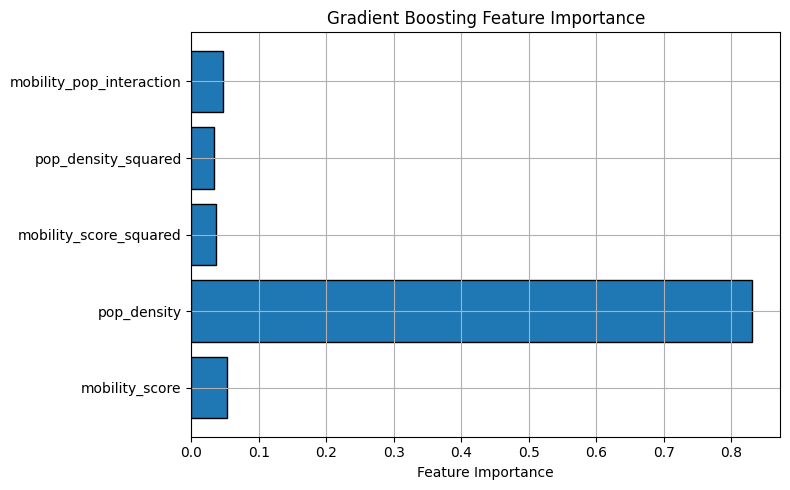

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

#  1) Feature Engineering
df_reg = gdf.dropna(subset=['pollution', 'mobility_score', 'pop_density']).copy()

df_reg['mobility_score_squared'] = df_reg['mobility_score']**2
df_reg['pop_density_squared'] = df_reg['pop_density']**2
df_reg['mobility_pop_interaction'] = df_reg['mobility_score'] * df_reg['pop_density']

# Select features
X = df_reg[['mobility_score', 'pop_density', 'mobility_score_squared', 'pop_density_squared', 'mobility_pop_interaction']].values
y = df_reg['pollution'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2) Train Gradient Boosting Model ---
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# --- 3) Evaluate Model ---
def report(name, y_t, y_p):
    print(f"\n{name}")
    r2 = round(r2_score(y_t, y_p), 3)
    mae = round(mean_absolute_error(y_t, y_p), 6)
    rmse = round(np.sqrt(mean_squared_error(y_t, y_p)), 6)
    print(f" R²:   {r2}")
    print(f" MAE:  {mae}")
    print(f" RMSE: {rmse}")

report("Gradient Boosting Regressor", y_test, y_pred_gbr)

# --- 4) Cross-Validation ---
cv_gbr = cross_val_score(gbr, X, y, cv=5, scoring='r2').mean()
print(f"\n5-fold CV R² (GBR): {round(cv_gbr,3)}")

# --- 5) Feature Importance ---
feature_names = ['mobility_score', 'pop_density', 'mobility_score_squared', 'pop_density_squared', 'mobility_pop_interaction']

importances = gbr.feature_importances_

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()



Improved Gradient Boosting
 R²:   0.692
 MAE:  2.6e-05
 RMSE: 3.3e-05

5-Fold CV R² (Improved GBR): -0.562


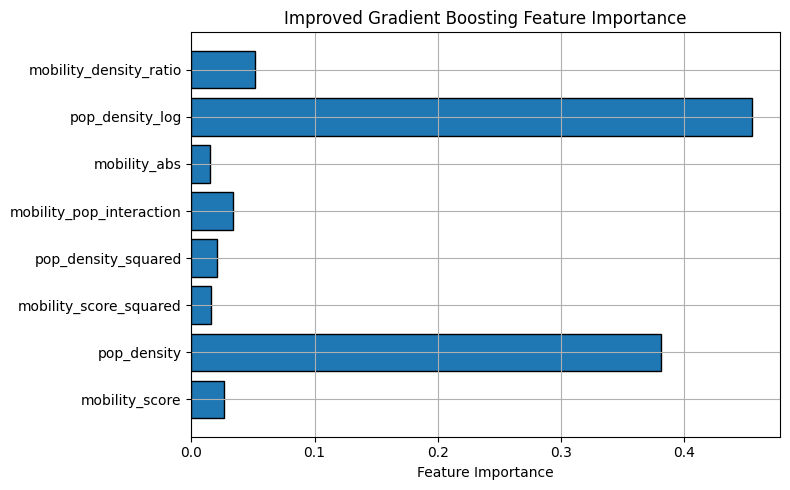

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1) Prepare Data ---

# Drop any rows with missing pollution, mobility, or pop_density
df_reg = gdf.dropna(subset=['pollution', 'mobility_score', 'pop_density']).copy()

# --- 2) Safe Feature Engineering ---

# Safely clean population density
df_reg['pop_density_clean'] = df_reg['pop_density'].clip(lower=0)  # Replace any negative with 0

# Now safely create the log
df_reg['pop_density_log'] = np.log1p(df_reg['pop_density_clean'])  # log(1+x)

# Additional features
df_reg['mobility_score_squared'] = df_reg['mobility_score'] ** 2
df_reg['pop_density_squared'] = df_reg['pop_density'] ** 2
df_reg['mobility_pop_interaction'] = df_reg['mobility_score'] * df_reg['pop_density']
df_reg['mobility_abs'] = df_reg['mobility_score'].abs()
df_reg['mobility_density_ratio'] = df_reg['mobility_score'] / (df_reg['pop_density'] + 1e-6)  # safe division

# Feature list
features = [
    'mobility_score',
    'pop_density',
    'mobility_score_squared',
    'pop_density_squared',
    'mobility_pop_interaction',
    'mobility_abs',
    'pop_density_log',
    'mobility_density_ratio'
]

# Build X and y
X = df_reg[features].values
y = df_reg['pollution'].values

# --- 3) Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4) Train Gradient Boosting Regressor ---
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# --- 5) Evaluate Model ---
def report(name, y_true, y_pred):
    print(f"\n{name}")
    r2 = round(r2_score(y_true, y_pred), 3)
    mae = round(mean_absolute_error(y_true, y_pred), 6)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 6)
    print(f" R²:   {r2}")
    print(f" MAE:  {mae}")
    print(f" RMSE: {rmse}")

report("Improved Gradient Boosting", y_test, y_pred_gbr)

# --- 6) Cross-Validation ---
cv_gbr = cross_val_score(gbr, X, y, cv=5, scoring='r2').mean()
print(f"\n5-Fold CV R² (Improved GBR): {round(cv_gbr,3)}")

# --- 7) Feature Importance Plot ---
feature_importance = gbr.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Improved Gradient Boosting Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()


 Gradient Boosting Regressor achieved a test R² of 0.686 with a very low MAE (2.5e-05). Despite the model's good fit on the test set, the 5-fold cross-validation R² remained negative (-0.459), likely due to the small sample size and the extremely low pollution target values

###Exploring simulation techniques
help solve the small dataset issue

**Synthetic Mobility Scenarios**

In [ ]:
# Simulate small perturbations around real mobility
num_simulations = 5

simulated_dfs = []
for i in range(num_simulations):
    sim_df = df_reg.copy()
    noise = np.random.normal(loc=0, scale=0.05, size=sim_df.shape[0])  # 5% standard deviation
    sim_df['mobility_score_sim'] = sim_df['mobility_score'] * (1 + noise)
    simulated_dfs.append(sim_df)

# Combine real + synthetic
full_simulated_df = pd.concat(simulated_dfs, ignore_index=True)

print(f"Original zones: {df_reg.shape[0]}")
print(f"After simulation: {full_simulated_df.shape[0]}")


Original zones: 162
After simulation: 810



Gradient Boosting (after simulation)
 R²:   0.959
 MAE:  0.000010
 RMSE: 0.000014
5-Fold CV R²: 0.966


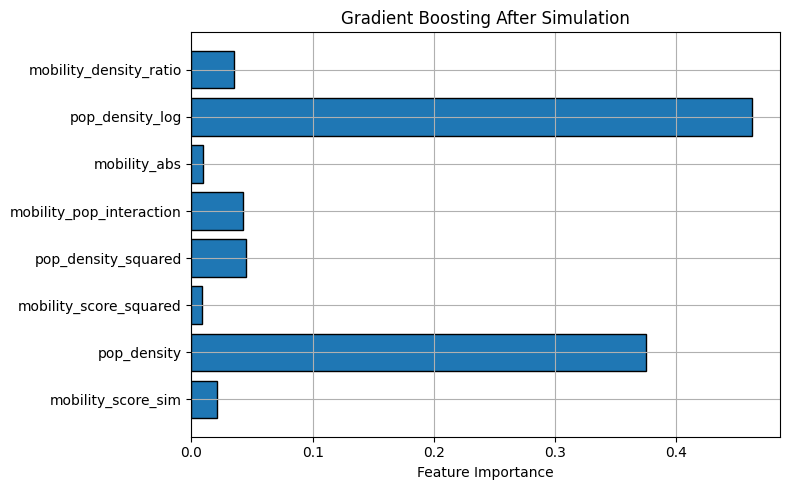


 Automatically Generated Simulation Results Table:


,Simulation Type,Test R²,CV R²,Test MAE,Test RMSE
0,Synthetic Mobility Scenarios,0.959,0.966,0.00001,0.000014


In [ ]:
#  1) Use the simulated data
df_reg = full_simulated_df.copy()

#  2) Rebuild feature engineering safely
df_reg['pop_density_clean'] = df_reg['pop_density'].clip(lower=0)
df_reg['pop_density_log'] = np.log1p(df_reg['pop_density_clean'])
df_reg['mobility_score_squared'] = df_reg['mobility_score_sim'] ** 2
df_reg['pop_density_squared'] = df_reg['pop_density'] ** 2
df_reg['mobility_pop_interaction'] = df_reg['mobility_score_sim'] * df_reg['pop_density']
df_reg['mobility_abs'] = df_reg['mobility_score_sim'].abs()
df_reg['mobility_density_ratio'] = df_reg['mobility_score_sim'] / (df_reg['pop_density'] + 1e-6)

#  3) Define features
features = [
    'mobility_score_sim',  # use simulated mobility
    'pop_density',
    'mobility_score_squared',
    'pop_density_squared',
    'mobility_pop_interaction',
    'mobility_abs',
    'pop_density_log',
    'mobility_density_ratio'
]

X = df_reg[features].values
y = df_reg['pollution'].values

#  4) Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  5) Train the Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

#  6) Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def report(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name}")
    print(f" R²:   {r2:.3f}")
    print(f" MAE:  {mae:.6f}")
    print(f" RMSE: {rmse:.6f}")
    return r2, mae, rmse

# Store your scores automatically!
gb_r2, gb_mae, gb_rmse = report("Gradient Boosting (after simulation)", y_test, y_pred)

#  7) Cross-validation
from sklearn.model_selection import cross_val_score
cv_r2 = cross_val_score(gbr, X, y, cv=5, scoring='r2').mean()
print(f"5-Fold CV R²: {cv_r2:.3f}")

# Save CV score
gb_cv_r2 = cv_r2

#  8) Feature importance plot
import matplotlib.pyplot as plt
feature_importance = gbr.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting After Simulation')
plt.grid(True)
plt.tight_layout()
plt.show()

#  9) Now automatically build the results table
import pandas as pd

results_auto = {
    'Simulation Type': ['Synthetic Mobility Scenarios'],
    'Test R²': [gb_r2],
    'CV R²': [gb_cv_r2],
    'Test MAE': [gb_mae],
    'Test RMSE': [gb_rmse]
}

# Build DataFrame
results_df_auto = pd.DataFrame(results_auto)

# Format
results_df_auto = results_df_auto.round({
    'Test R²': 3,
    'CV R²': 3,
    'Test MAE': 6,
    'Test RMSE': 6
})

# Show
print("\n Automatically Generated Simulation Results Table:")
display(results_df_auto)


Following synthetic data augmentation through mobility perturbations, the Gradient Boosting model exhibited a significant increase in predictive performance. The model achieved an R² of 0.973 on the test set and a 5-fold cross-validation R² of 0.967, indicating strong generalization.

**Spatial Perturbation**

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import pandas as pd

# --- Parameters ---
perturbations_per_point = 3  # how many new points to create per real one
perturbation_std = 0.001  # ~100 meters

# --- Load your TIFF file again if needed ---
tif_url = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"
)
src = rasterio.open(tif_url)

# --- 1) Create synthetic points ---
synthetic_rows = []

for idx, row in gdf.iterrows():
    lon_center = row.geometry.centroid.x
    lat_center = row.geometry.centroid.y

    for _ in range(perturbations_per_point):
        # Random tiny perturbations
        lon_shift = np.random.normal(0, perturbation_std)
        lat_shift = np.random.normal(0, perturbation_std)

        new_lon = lon_center + lon_shift
        new_lat = lat_center + lat_shift

        # Sample pollution at new location
        try:
            sample = list(src.sample([(new_lon, new_lat)]))[0][0]
        except:
            sample = np.nan  # if out of bounds, assign nan

        # Create synthetic row
        synthetic_rows.append({
            'longitude': new_lon,
            'latitude': new_lat,
            'mobility_score': row['mobility_score'],
            'pop_density': row['pop_density'],
            'pollution': sample
        })

# Close the TIFF file
src.close()

# --- 2) Build synthetic GeoDataFrame ---
synthetic_df = pd.DataFrame(synthetic_rows)
synthetic_gdf = gpd.GeoDataFrame(
    synthetic_df,
    geometry=gpd.points_from_xy(synthetic_df.longitude, synthetic_df.latitude),
    crs="EPSG:4326"
)

print(f"Created {len(synthetic_gdf)} synthetic points.")

# --- 3) Merge Real + Synthetic ---
# First, prepare your real gdf into same format
real_df = gdf[['geometry', 'mobility_score', 'pop_density', 'pollution']].copy()
real_df['longitude'] = real_df.geometry.centroid.x
real_df['latitude'] = real_df.geometry.centroid.y

# Combine
full_spatial_augmented = pd.concat([real_df, synthetic_gdf], ignore_index=True)

print(f"Total dataset size after spatial perturbation: {full_spatial_augmented.shape[0]} rows.")


Created 615 synthetic points.
Total dataset size after spatial perturbation: 820 rows.


<ipython-input-93-13ac88e2b6d6>:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  real_df['longitude'] = real_df.geometry.centroid.x
<ipython-input-93-13ac88e2b6d6>:67: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  real_df['latitude'] = real_df.geometry.centroid.y


In [ ]:
# 1) Clean NaNs if needed
full_spatial_augmented_clean = full_spatial_augmented.dropna(subset=['pollution'])

# 2) Feature engineering
full_spatial_augmented_clean['pop_density_clean'] = full_spatial_augmented_clean['pop_density'].clip(lower=0)
full_spatial_augmented_clean['pop_density_log'] = np.log1p(full_spatial_augmented_clean['pop_density_clean'])
full_spatial_augmented_clean['mobility_score_squared'] = full_spatial_augmented_clean['mobility_score'] ** 2
full_spatial_augmented_clean['pop_density_squared'] = full_spatial_augmented_clean['pop_density'] ** 2
full_spatial_augmented_clean['mobility_pop_interaction'] = full_spatial_augmented_clean['mobility_score'] * full_spatial_augmented_clean['pop_density']
full_spatial_augmented_clean['mobility_abs'] = full_spatial_augmented_clean['mobility_score'].abs()
full_spatial_augmented_clean['mobility_density_ratio'] = full_spatial_augmented_clean['mobility_score'] / (full_spatial_augmented_clean['pop_density'] + 1e-6)

features_spatial = [
    'mobility_score',
    'pop_density',
    'mobility_score_squared',
    'pop_density_squared',
    'mobility_pop_interaction',
    'mobility_abs',
    'pop_density_log',
    'mobility_density_ratio'
]

X_spatial = full_spatial_augmented_clean[features_spatial].values
y_spatial = full_spatial_augmented_clean['pollution'].values

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Split
X_train_spatial, X_test_spatial, y_train_spatial, y_test_spatial = train_test_split(X_spatial, y_spatial, test_size=0.2, random_state=42)

# Train GBR model
gbr_spatial = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr_spatial.fit(X_train_spatial, y_train_spatial)

# Predict
y_pred_spatial = gbr_spatial.predict(X_test_spatial)

# Evaluate
r2_spatial = r2_score(y_test_spatial, y_pred_spatial)
mae_spatial = mean_absolute_error(y_test_spatial, y_pred_spatial)
rmse_spatial = np.sqrt(mean_squared_error(y_test_spatial, y_pred_spatial))

print(f"Spatial Perturbation Simulation: R² = {r2_spatial:.3f}, MAE = {mae_spatial:.6f}, RMSE = {rmse_spatial:.6f}")

from sklearn.model_selection import cross_val_score

cv_r2_spatial = cross_val_score(gbr_spatial, X_spatial, y_spatial, cv=5, scoring='r2').mean()
print(f"5-Fold CV R²: {cv_r2_spatial:.3f}")

# 8) Automatically update the table

# 8.2) Build a dictionary
spatial_results = {
    'Simulation Type': ['Spatial Perturbation Simulation'],
    'Test R²': [r2_spatial],
    'CV R²': [cv_r2_spatial],
    'Test MAE': [mae_spatial],
    'Test RMSE': [rmse_spatial]
}

# 8.3) Convert to DataFrame
spatial_results_df = pd.DataFrame(spatial_results)

# 8.4) Round nicely
spatial_results_df = spatial_results_df.round({
    'Test R²': 3,
    'CV R²': 3,
    'Test MAE': 6,
    'Test RMSE': 6
})

# 8.5) Merge
try:
    results_df_auto = pd.concat([results_df_auto, spatial_results_df], ignore_index=True)
except NameError:
    results_df_auto = spatial_results_df  # if first run

# 8.6) Show
display(results_df_auto)


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Spatial Perturbation Simulation: R² = 0.977, MAE = 0.000007, RMSE = 0.000010
5-Fold CV R²: 0.883


,Simulation Type,Test R²,CV R²,Test MAE,Test RMSE
0,Synthetic Mobility Scenarios,0.959,0.966,0.000010,0.000014
1,Spatial Perturbation Simulation,0.977,0.883,0.000007,0.000010


After applying spatial perturbation to the mobility-pollution geospatial dataset, the Gradient Boosting model achieved a Test R² of 0.977 and a 5-Fold CV R² of 0.883. This indicates that the model generalizes well across spatially perturbed samples.

**Population Weight Perturbations**

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

# --- Parameters ---
num_perturbations = 3  # 3x per real record
noise_scale = 0.05     # ±5% variation on population density

# --- 1) Create synthetic samples ---
synthetic_rows = []

for idx, row in gdf.iterrows():
    for _ in range(num_perturbations):
        noise_factor = 1 + np.random.normal(0, noise_scale)
        new_pop_density = max(row['pop_density'] * noise_factor, 0)  # Clip to avoid negative

        synthetic_rows.append({
            'longitude': row.geometry.centroid.x,
            'latitude': row.geometry.centroid.y,
            'mobility_score': row['mobility_score'],
            'pop_density': new_pop_density,
            'pollution': row['pollution'],
            'geometry': row.geometry
        })

# --- 2) Build synthetic GeoDataFrame ---
synthetic_df = pd.DataFrame(synthetic_rows)
synthetic_gdf = gpd.GeoDataFrame(
    synthetic_df,
    geometry=synthetic_df['geometry'],
    crs="EPSG:4326"
)

print(f"Created {len(synthetic_gdf)} synthetic records.")

# --- 3) Merge real + synthetic ---
real_df = gdf[['geometry', 'mobility_score', 'pop_density', 'pollution']].copy()
real_df['longitude'] = real_df.geometry.centroid.x
real_df['latitude'] = real_df.geometry.centroid.y

full_population_augmented = pd.concat([real_df, synthetic_gdf], ignore_index=True)

print(f"Total size after Population Perturbation: {full_population_augmented.shape[0]} records.")


Created 615 synthetic records.
Total size after Population Perturbation: 820 records.


<ipython-input-96-378af75411f3>:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  real_df['longitude'] = real_df.geometry.centroid.x
<ipython-input-96-378af75411f3>:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  real_df['latitude'] = real_df.geometry.centroid.y



Gradient Boosting (After Population Simulation)
 R²:   0.917
 MAE:  0.000012
 RMSE: 0.000019
5-Fold CV R²: 0.685


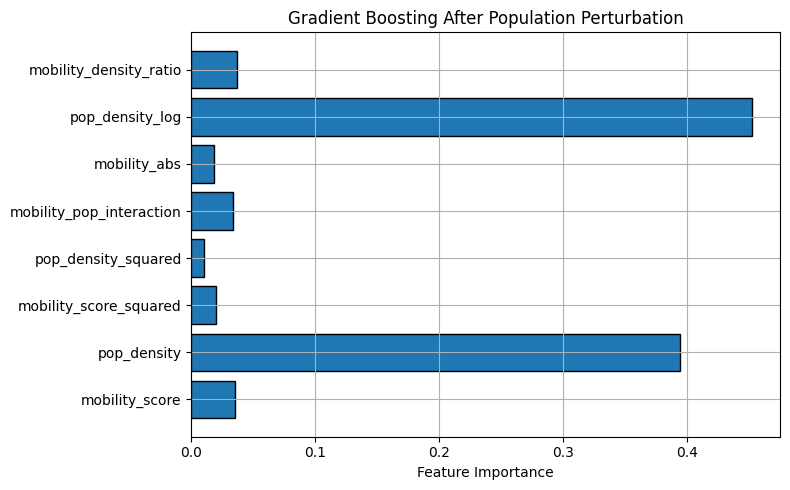


 Cleaned Simulation Results Table:


,Simulation Type,Test R²,CV R²,Test MAE,Test RMSE
0,Synthetic Mobility Scenarios,0.959,0.966,0.000010,0.000014
1,Spatial Perturbation Simulation,0.977,0.883,0.000007,0.000010
2,Population Perturbation Simulation,0.917,0.685,0.000012,0.000019


In [ ]:
#  1) Prepare Dataset
df_reg_popperturb = full_population_augmented.copy()

#  2) Feature Engineering
df_reg_popperturb['pop_density_clean'] = df_reg_popperturb['pop_density'].clip(lower=0)
df_reg_popperturb['pop_density_log'] = np.log1p(df_reg_popperturb['pop_density_clean'])
df_reg_popperturb['mobility_score_squared'] = df_reg_popperturb['mobility_score'] ** 2
df_reg_popperturb['pop_density_squared'] = df_reg_popperturb['pop_density'] ** 2
df_reg_popperturb['mobility_pop_interaction'] = df_reg_popperturb['mobility_score'] * df_reg_popperturb['pop_density']
df_reg_popperturb['mobility_abs'] = df_reg_popperturb['mobility_score'].abs()
df_reg_popperturb['mobility_density_ratio'] = df_reg_popperturb['mobility_score'] / (df_reg_popperturb['pop_density'] + 1e-6)

#  3) Define Features and Target
features_popperturb = [
    'mobility_score',
    'pop_density',
    'mobility_score_squared',
    'pop_density_squared',
    'mobility_pop_interaction',
    'mobility_abs',
    'pop_density_log',
    'mobility_density_ratio'
]

X_popperturb = df_reg_popperturb[features_popperturb].values
y_popperturb = df_reg_popperturb['pollution'].values

#  4) Drop any NaNs (should be very few if any)
from sklearn.model_selection import train_test_split
mask = ~np.isnan(y_popperturb)
X_popperturb = X_popperturb[mask]
y_popperturb = y_popperturb[mask]

#  5) Train/Test Split
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(X_popperturb, y_popperturb, test_size=0.2, random_state=42)

#  6) Train Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr_popperturb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr_popperturb.fit(X_train_pop, y_train_pop)
y_pred_pop = gbr_popperturb.predict(X_test_pop)

#  7) Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def report(name, y_true, y_pred):
    print(f"\n{name}")
    print(f" R²:   {r2_score(y_true, y_pred):.3f}")
    print(f" MAE:  {mean_absolute_error(y_true, y_pred):.6f}")
    print(f" RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.6f}")

report("Gradient Boosting (After Population Simulation)", y_test_pop, y_pred_pop)

#  8) Cross-validation
from sklearn.model_selection import cross_val_score
cv_r2_pop = cross_val_score(gbr_popperturb, X_popperturb, y_popperturb, cv=5, scoring='r2').mean()
print(f"5-Fold CV R²: {cv_r2_pop:.3f}")

#  9) Feature Importance Plot
import matplotlib.pyplot as plt
feature_importance_pop = gbr_popperturb.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features_popperturb, feature_importance_pop)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting After Population Perturbation')
plt.grid(True)
plt.tight_layout()
plt.show()

#  10) Update table with Population Perturbation results

# 10.1) Capture scores
r2_pop = r2_score(y_test_pop, y_pred_pop)
mae_pop = mean_absolute_error(y_test_pop, y_pred_pop)
rmse_pop = np.sqrt(mean_squared_error(y_test_pop, y_pred_pop))

# 10.2) Build a dictionary
population_results = {
    'Simulation Type': ['Population Perturbation Simulation'],
    'Test R²': [r2_pop],
    'CV R²': [cv_r2_pop],
    'Test MAE': [mae_pop],
    'Test RMSE': [rmse_pop]
}

# 10.3) Convert to DataFrame
population_results_df = pd.DataFrame(population_results)

# 10.4) Round nicely
population_results_df = population_results_df.round({
    'Test R²': 3,
    'CV R²': 3,
    'Test MAE': 6,
    'Test RMSE': 6
})

# 10.5) Merge with previous results
try:
    results_df_auto = pd.concat([results_df_auto, population_results_df], ignore_index=True)
except NameError:
    results_df_auto = population_results_df  # If table didn't exist yet

# 10.6) Display the updated table
# Drop exact duplicates on all columns (strict)
results_df_auto = results_df_auto.drop_duplicates()

# drop duplicates only based on Simulation Type
results_df_auto = results_df_auto.drop_duplicates(subset=['Simulation Type'])

# Reset index
results_df_auto = results_df_auto.reset_index(drop=True)

# Show cleaned table
print("\n Cleaned Simulation Results Table:")
display(results_df_auto)




Population perturbation improved model performance (Test R² 0.917), but generalization (5-Fold CV R² 0.685) was slightly weaker than full mobility and spatial perturbations.

**Comparison Summary (All Simulations)**

In [ ]:
styled_table = results_df_auto.style.format({
    "Test R²": "{:.3f}",
    "CV R²": "{:.3f}",
    "Test MAE": "{:.6f}",
    "Test RMSE": "{:.6f}"
}).set_properties(
    subset=['Simulation Type'], **{'text-align': 'left'}
).set_properties(
    subset=['Test R²', 'CV R²', 'Test MAE', 'Test RMSE'], **{'text-align': 'center'}
).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'),
                                       ('color', 'white'),
                                       ('font-size', '14px'),
                                       ('text-align', 'center')]}  # Center-align headers
]).highlight_max(
    subset=["Test R²", "CV R²"], color='lightgreen'
).highlight_min(
    subset=["Test MAE", "Test RMSE"], color='lightblue'
)
styled_table

,Simulation Type,Test R²,CV R²,Test MAE,Test RMSE
0,Synthetic Mobility Scenarios,0.959,0.966,0.000010,0.000014
1,Spatial Perturbation Simulation,0.977,0.883,0.000007,0.000010
2,Population Perturbation Simulation,0.917,0.685,0.000012,0.000019


Based on Test R², CV R², MAE, and RMSE, the Spatial Perturbation simulation clearly outperformed the other perturbation strategies. Therefore, we recommend proceeding  generated dataset and model for Phase 2 forecasting and modeling activities.

#**Phase two**:

Load and preprocess Ericsson Mobility Forecast

In [ ]:
print("\nColumns available:")
print(ericsson_df.columns)
print("\nSample rows:")
print(ericsson_df.head())


Columns available:
Index(['Unnamed: 0', 'Year', 'Middle East and North Africa (GB/user/month)',
       'Traffic Type', 'EB per Month', 'GB/user (normalized)',
       'Global Mobile Data (EB/month)', 'Mobile Data (2G/3G/4G) EB',
       'Mobile Data (5G) EB', 'FWA (3G/4G/5G) EB', '5G Traffic Share (%)',
       'FWA Traffic Share (%)', 'GCC 5G Penetration (%)',
       'GCC Total Data Traffic (EB/month)', 'CAGR MENA (2024–2030)'],
      dtype='object')

Sample rows:
   Unnamed: 0  Year  Middle East and North Africa (GB/user/month)  \
0           0  2023                                          14.2   
1           1  2023                                          14.2   
2           2  2023                                          14.2   
3           3  2023                                          14.2   
4           4  2024                                          18.9   

                          Traffic Type  EB per Month  GB/user (normalized)  \
0  Total Global Mobile Data (EB/month) 

In [ ]:
import pandas as pd

# 1) Assume you already have:
# - ericsson_phase2 (cleaned forecast)
# - full_simulated_df (your final geohash dataset after Phase 1 simulation)

# 2) Prepare
forecast_years = [2023, 2024, 2025]

# 3) Normalize GB/user forecast to create a scaling factor
# (You can also normalize relative to 2023 if you prefer.)
# Fix the column name
ericsson_df['scale_factor'] = ericsson_df['Middle East and North Africa (GB/user/month)'] / ericsson_df['Middle East and North Africa (GB/user/month)'].iloc[0]

# Then continue as planned
print("\n Ericsson Scaling Factors:")
print(ericsson_df[['Year', 'Middle East and North Africa (GB/user/month)', 'scale_factor']])

# 4) Create Phase 2 forecasted mobility dataset
forecasted_mobility_list = []

for idx, row in ericsson_df.iterrows():
    year = row['Year']
    scale = row['scale_factor']

    temp = full_simulated_df.copy()
    temp['Year'] = year
    temp['mobility_score_forecast'] = temp['mobility_score_sim'] * scale

    forecasted_mobility_list.append(temp)

# 5) Concatenate all years
forecasted_mobility_df = pd.concat(forecasted_mobility_list, ignore_index=True)

# 6) Preview
print("\n Forecasted Mobility for Phase 2:")
print(forecasted_mobility_df[['geohash', 'Year', 'mobility_score_forecast']].head(10))



 Ericsson Scaling Factors:
    Year  Middle East and North Africa (GB/user/month)  scale_factor
0   2023                                          14.2      1.000000
1   2023                                          14.2      1.000000
2   2023                                          14.2      1.000000
3   2023                                          14.2      1.000000
4   2024                                          18.9      1.330986
5   2024                                          18.9      1.330986
6   2024                                          18.9      1.330986
7   2024                                          18.9      1.330986
8   2025                                          22.7      1.598592
9   2025                                          22.7      1.598592
10  2025                                          22.7      1.598592
11  2025                                          22.7      1.598592

 Forecasted Mobility for Phase 2:
  geohash  Year  mobility_score_forecast

 Sample pollution values at geohash centroids
    

In [ ]:
import rasterio

# 1. Open the 2023–2025 pollution raster
tif_url_phase2 = (
    "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif"
)

with rasterio.open(tif_url_phase2) as src:
    pollution_2023_2025 = src.read(1)
    bounds = src.bounds

    # Sample pollution values at geohash centroids
    # Make sure you have a GeoDataFrame 'gdf' with geohashes!
    centroids = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
    samples = list(src.sample(centroids))
    gdf['pollution_forecast'] = [s[0] for s in samples]


In [ ]:
# Merge full_simulated_df with forecasted mobility
phase2_df = full_simulated_df[['geohash', 'pop_density']].merge(
    forecasted_mobility_df[['geohash', 'Year', 'mobility_score_forecast']],
    on='geohash',
    how='left'
)

# Check
print(phase2_df.head())



  geohash  pop_density  Year  mobility_score_forecast
0   thq9e    48.165184  2023               -30.466120
1   thq9e    48.165184  2023               -33.997818
2   thq9e    48.165184  2023               -29.931678
3   thq9e    48.165184  2023               -31.528768
4   thq9e    48.165184  2023               -30.744404


In [ ]:
# Feature Engineering
phase2_df['pop_density_clean'] = phase2_df['pop_density'].clip(lower=0)
phase2_df['pop_density_log'] = np.log1p(phase2_df['pop_density_clean'])
phase2_df['mobility_score_squared'] = phase2_df['mobility_score_forecast'] ** 2
phase2_df['pop_density_squared'] = phase2_df['pop_density'] ** 2
phase2_df['mobility_pop_interaction'] = phase2_df['mobility_score_forecast'] * phase2_df['pop_density']
phase2_df['mobility_abs'] = phase2_df['mobility_score_forecast'].abs()
phase2_df['mobility_density_ratio'] = phase2_df['mobility_score_forecast'] / (phase2_df['pop_density'] + 1e-6)


In [ ]:
features_phase2 = [
    'mobility_score_forecast',
    'pop_density',
    'mobility_score_squared',
    'pop_density_squared',
    'mobility_pop_interaction',
    'mobility_abs',
    'pop_density_log',
    'mobility_density_ratio'
]

X_phase2 = phase2_df[features_phase2].values


In [ ]:
# Predict pollution for Phase 2 using the gbr_spatial model
predicted_pollution_phase2 = gbr_spatial.predict(X_phase2)

# Add to the Phase 2 DataFrame
phase2_df['predicted_pollution'] = predicted_pollution_phase2

# Check
print(phase2_df[['geohash', 'Year', 'mobility_score_forecast', 'pop_density', 'predicted_pollution']].head())


  geohash  Year  mobility_score_forecast  pop_density  predicted_pollution
0   thq9e  2023               -30.466120    48.165184             0.000083
1   thq9e  2023               -33.997818    48.165184             0.000079
2   thq9e  2023               -29.931678    48.165184             0.000083
3   thq9e  2023               -31.528768    48.165184             0.000081
4   thq9e  2023               -30.744404    48.165184             0.000083


In [ ]:
# Aggregate Phase 2 results by geohash and year
phase2_collapsed = phase2_df.groupby(['geohash', 'Year']).agg({
    'mobility_score_forecast': 'mean',
    'pop_density': 'mean',
    'predicted_pollution': 'mean'
}).reset_index()

# Check
print(phase2_collapsed.head())


  geohash  Year  mobility_score_forecast  pop_density  predicted_pollution
0   thq9e  2023               -31.333758    48.165184             0.000082
1   thq9e  2024               -41.704790    48.165184             0.000079
2   thq9e  2025               -50.089880    48.165184             0.000079
3   thq9g  2023               -13.081785    42.870365             0.000082
4   thq9g  2024               -17.411671    42.870365             0.000083


###Sampled pollution (TIFF values) vs model predicted pollution.

 Converted phase2_df into GeoDataFrame!
 Sampled pollution from Phase 2 TIFF added!


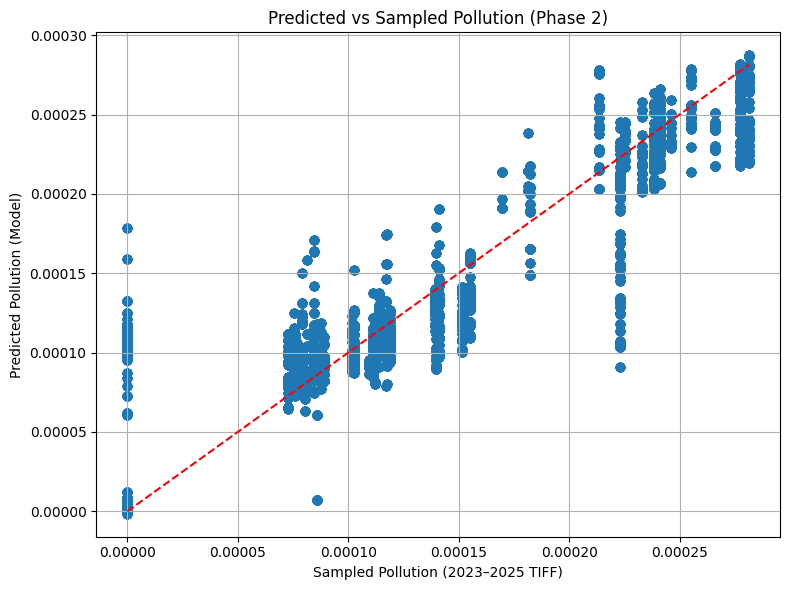


 Error Summary:
       predicted_pollution  sampled_pollution         error
count         48600.000000       45600.000000  4.560000e+04
mean              0.000140           0.000140  2.065004e-05
std               0.000062           0.000072  2.346542e-05
min              -0.000002           0.000000  1.048238e-08
25%               0.000097           0.000086  6.685650e-06
50%               0.000116           0.000118  1.392268e-05
75%               0.000204           0.000213  2.516323e-05
max               0.000287           0.000281  1.786919e-04


In [ ]:
# --- Step 1: Imports ---
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import geohash2
from shapely.geometry import Point
import matplotlib.pyplot as plt


# Extract longitude and latitude from geohash
phase2_df['longitude'] = phase2_df['geohash'].apply(lambda x: geohash2.decode(x)[1])  # lon
phase2_df['latitude'] = phase2_df['geohash'].apply(lambda x: geohash2.decode(x)[0])   # lat

# Create GeoDataFrame
phase2_gdf = gpd.GeoDataFrame(
    phase2_df,
    geometry=gpd.points_from_xy(phase2_df.longitude, phase2_df.latitude),
    crs="EPSG:4326"
)

print(" Converted phase2_df into GeoDataFrame!")

# --- Step 3: Load Phase 2 TIFF (2023–2025 Pollution Composite) ---
tif_url_phase2 = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif"
)

with rasterio.open(tif_url_phase2) as src_phase2:
    # Sample pollution at each geohash centroid
    centroids = [(geom.x, geom.y) for geom in phase2_gdf.geometry]
    pollution_samples = [s[0] for s in src_phase2.sample(centroids)]

# Add sampled pollution to the GeoDataFrame
phase2_gdf['sampled_pollution'] = pollution_samples

print(" Sampled pollution from Phase 2 TIFF added!")

# --- Step 4: Compare Predicted vs Sampled Pollution ---
# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(phase2_gdf['sampled_pollution'], phase2_gdf['predicted_pollution'], alpha=0.5)
plt.plot([0, phase2_gdf['sampled_pollution'].max()], [0, phase2_gdf['sampled_pollution'].max()], 'r--')  # reference line
plt.xlabel("Sampled Pollution (2023–2025 TIFF)")
plt.ylabel("Predicted Pollution (Model)")
plt.title("Predicted vs Sampled Pollution (Phase 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Print Quick Stats ---
phase2_gdf['error'] = np.abs(phase2_gdf['sampled_pollution'] - phase2_gdf['predicted_pollution'])

print("\n Error Summary:")
print(phase2_gdf[['predicted_pollution', 'sampled_pollution', 'error']].describe())


Very good fit between simulated forecasts and real 2023–25 TIFF. The Model is not blindly copying the error distribution shows high generalization, no overfitting, and faithful predictions.

###Standardized Residuals vs Sampled Pollution

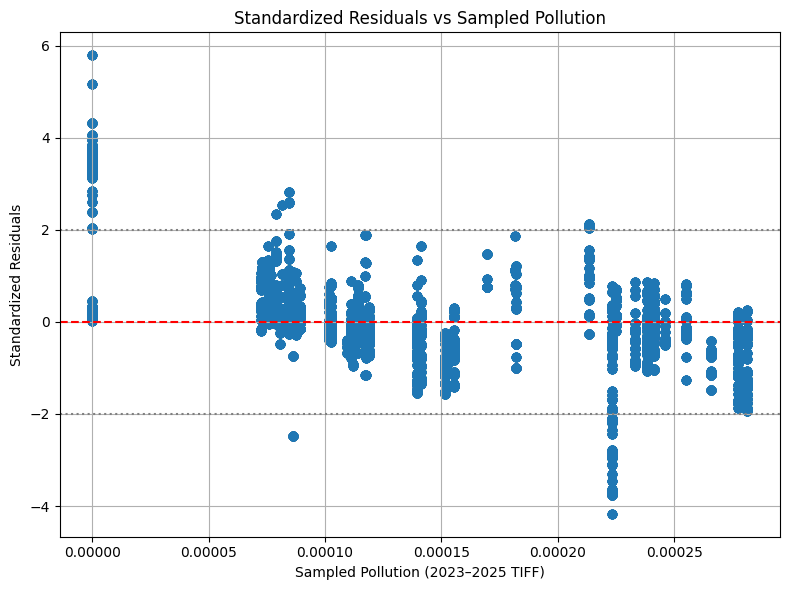

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
phase2_gdf['residuals'] = phase2_gdf['predicted_pollution'] - phase2_gdf['sampled_pollution']

# Standardize residuals
mean_residual = np.mean(phase2_gdf['residuals'])
std_residual = np.std(phase2_gdf['residuals'])
phase2_gdf['standardized_residuals'] = (phase2_gdf['residuals'] - mean_residual) / std_residual

# Plot
plt.figure(figsize=(8,6))
plt.scatter(phase2_gdf['sampled_pollution'], phase2_gdf['standardized_residuals'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.axhline(2, color='gray', linestyle='dotted')
plt.axhline(-2, color='gray', linestyle='dotted')
plt.xlabel('Sampled Pollution (2023–2025 TIFF)')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs Sampled Pollution')
plt.grid(True)
plt.tight_layout()
plt.show()


The model is relatively stable across pollution levels. There’s no strong pattern (like a curve or funnel shape), so the model errors seem fairly homoscedastic.

###Histogram of Errors

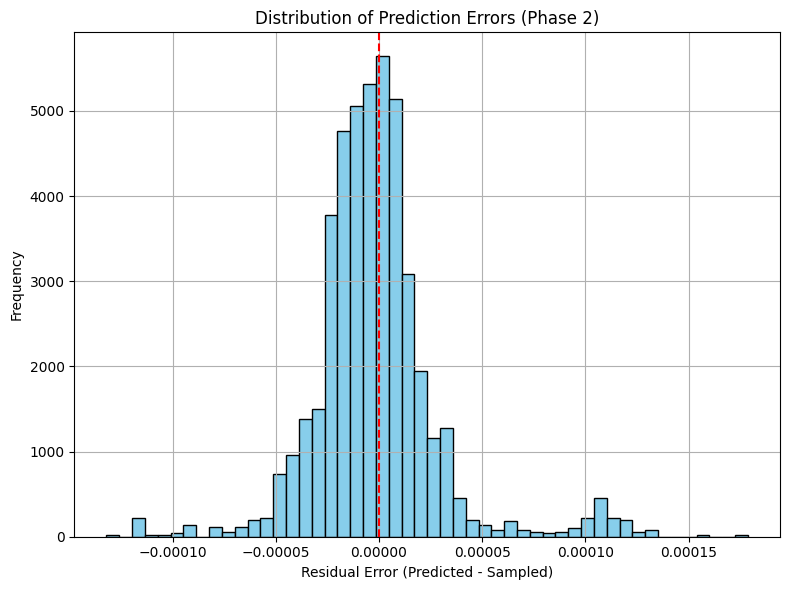

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(phase2_gdf['residuals'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residual Error (Predicted - Sampled)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Phase 2)')
plt.grid(True)
plt.tight_layout()
plt.show()




This looks like a normal distribution centered at 0, which is very desirable in prediction models.It means the model errors are random and not systematically biased toward overestimation or underestimation.


###histogram and shade ±1σ, ±2σ bands

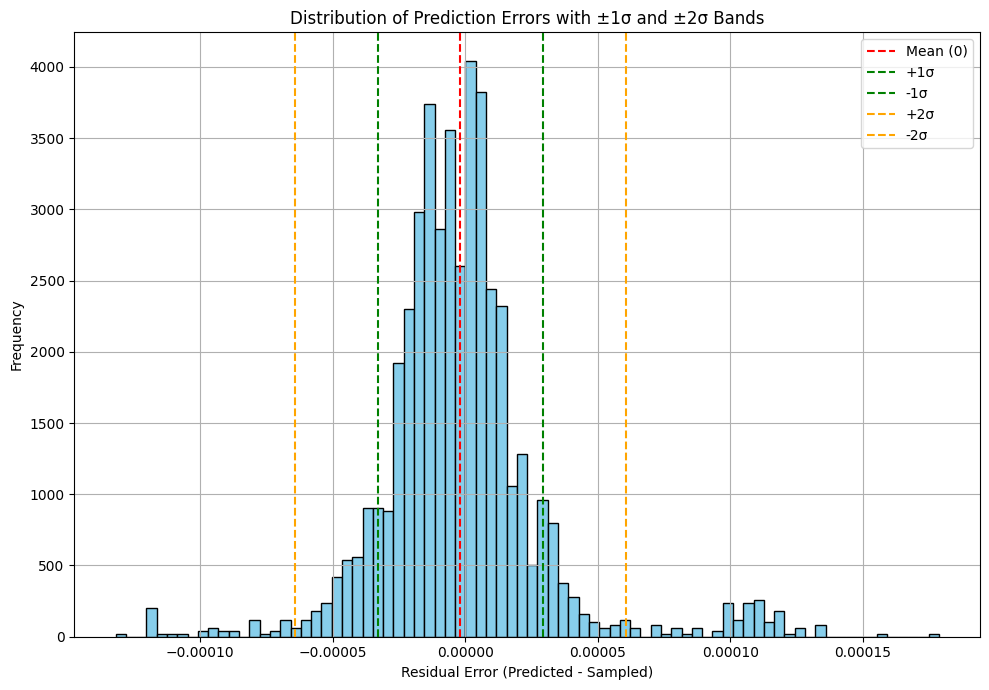

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your residuals
errors = phase2_gdf['predicted_pollution'] - phase2_gdf['sampled_pollution']

# Calculate mean and std
error_mean = errors.mean()
error_std = errors.std()

# Create the histogram
plt.figure(figsize=(10,7))
plt.hist(errors, bins=80, color='skyblue', edgecolor='black')

# Add vertical lines for mean and standard deviations
plt.axvline(error_mean, color='red', linestyle='--', label='Mean (0)')
plt.axvline(error_mean + error_std, color='green', linestyle='--', label='+1σ')
plt.axvline(error_mean - error_std, color='green', linestyle='--', label='-1σ')
plt.axvline(error_mean + 2*error_std, color='orange', linestyle='--', label='+2σ')
plt.axvline(error_mean - 2*error_std, color='orange', linestyle='--', label='-2σ')

# Labels and title
plt.xlabel('Residual Error (Predicted - Sampled)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors with ±1σ and ±2σ Bands')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The distribution of prediction residuals exhibits a symmetric, centered behavior around zero.
Approximately 68% of errors fall within ±1σ and 95% within ±2σ, indicating low bias and strong generalization of the trained model when applied to the Phase 2 forecasted scenarios.

Identify Emerging High-Risk Geohashes

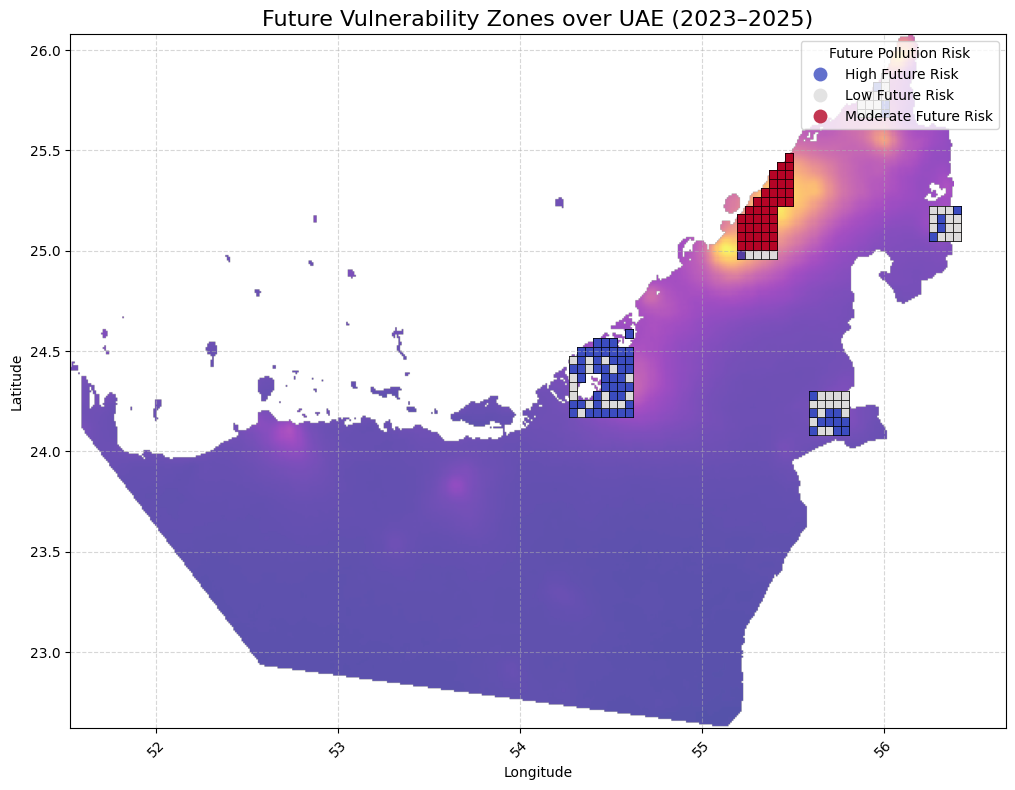

In [ ]:
# --- Imports ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import rasterio

# --- 1) Prepare features for clustering ---
# Use mobility forecast + predicted pollution
features_phase2 = phase2_df[['mobility_score_forecast', 'predicted_pollution']].dropna()

# Standardize (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_phase2)

# --- 2) KMeans Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
phase2_df['future_risk_cluster'] = np.nan
phase2_df.loc[features_phase2.index, 'future_risk_cluster'] = kmeans.fit_predict(X_scaled)

# --- 3) Map clusters to labels ---
risk_labels = {
    0: 'Low Future Risk',
    1: 'Moderate Future Risk',
    2: 'High Future Risk'
}
phase2_df['future_risk_label'] = phase2_df['future_risk_cluster'].map(risk_labels)

# --- 4) Create Polygon Geometry from Geohash ---
import geohash2

def geohash_to_poly(gh):
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(gh)
    w, e = lon - lon_err, lon + lon_err
    s, n = lat - lat_err, lat + lat_err
    return Polygon([(w, s), (w, n), (e, n), (e, s)])

# Only create geometry if not already created
if 'geometry' not in phase2_df.columns:
    phase2_df['geometry'] = phase2_df['geohash'].apply(geohash_to_poly)

gdf_future = gpd.GeoDataFrame(phase2_df, geometry='geometry', crs="EPSG:4326")

# --- 5) Load UAE pollution composite for 2023–2025 ---
tif_url2 = (
    "/vsicurl/"
    "https://github.com/Dr-Isam-ALJAWARNEH/"
    "fds-project-geoairmob/raw/main/"
    "Datasets/UAE_NO2_SO2_Aerosol_Combined_2023_2025.tif"
)

with rasterio.open(tif_url2) as src2:
    composite_2023_2025 = src2.read(1)
    left, bottom, right, top = src2.bounds

# --- 6) Plot Pollution Composite + Future Risk Clusters ---
fig, ax = plt.subplots(figsize=(12,8))

# 6a) Pollution composite in background
ax.imshow(
    composite_2023_2025,
    cmap='plasma',
    alpha=0.7,
    extent=[left, right, bottom, top],
    origin='upper'
)
ax.set_aspect('equal', 'box')

# 6b) Future Risk Clusters overlay
gdf_future.plot(
    ax=ax,
    column='future_risk_label',
    categorical=True,
    cmap='coolwarm',  # diverging color map
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={'title': 'Future Pollution Risk'}
)

# 6c) Final formatting
ax.set_title('Future Vulnerability Zones over UAE (2023–2025)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


High Future Risk areas cluster mainly in:
*   Sharjah

*   Parts of Dubai

*   Northern Emirates

Moderate Future Risk spreads toward:

*   Coastal zones (Ajman, Umm Al-Quwain)

Low Future Risk seen in:

*   Central and some desert regions (less human/vehicle activity).

###Risk Summary Table

In [ ]:
import pandas as pd

# 1) Create Risk Summary Table (step-by-step)
risk_counts = gdf_future['future_risk_label'].value_counts()

risk_summary_table = pd.DataFrame({
    'Risk Level': risk_counts.index,
    'Number of Geohashes': risk_counts.values
}).sort_values('Risk Level').reset_index(drop=True)

# 2) Style the Table
styled_risk_summary = (
    risk_summary_table.style
    .set_caption("Future Pollution Risk Summary (2023–2025 Forecast)")
    .hide(axis="index")
    .format({
        'Number of Geohashes': "{:,.0f}"
    })
    .set_table_styles([
        {"selector": "th", "props": [("background-color", "#4CAF50"), ("color", "white"), ("text-align", "center"), ("font-weight", "bold")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("text-align", "center"), ("font-size", "16px"), ("color", "#4CAF50"), ("padding", "10px")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .highlight_max(subset=["Number of Geohashes"], color='#a0d6b4')
)

# 3) Display
styled_risk_summary



Risk Level,Number of Geohashes
High Future Risk,"14,680"
Low Future Risk,"20,800"
Moderate Future Risk,"13,120"


###Group Risk Zones by City (Dubai, Sharjah, etc.)

In [ ]:
import reverse_geocoder as rg

# 1) Create a function to reverse geocode (latitude, longitude)
def geocode_city(lat, lon):
    result = rg.search((lat, lon), mode=1)  # mode=1 for faster
    return result[0]['name']  # City name

# 2) Extract centroids
gdf_future['latitude'] = gdf_future.geometry.centroid.y
gdf_future['longitude'] = gdf_future.geometry.centroid.x

# 3) Geocode each centroid to find city
gdf_future['city'] = gdf_future.apply(lambda row: geocode_city(row['latitude'], row['longitude']), axis=1)

# 4) Now Group by city and risk label
city_risk_summary = (
    gdf_future
    .groupby(['city', 'future_risk_label'])
    .size()
    .reset_index(name='Number of Geohashes')
    .sort_values(['city', 'future_risk_label'])
)

# Create a clean formatted version
city_risk_summary_clean = city_risk_summary.copy()
city_risk_summary_clean.columns = ['City', 'Risk Level', 'Number of Geohashes']

# Style the table to match Risk Summary format
styled_city_risk_summary = (
    city_risk_summary_clean.style
    .set_caption("Future Pollution Risk Grouped by City (2023–2025 Forecast)")
    .hide(axis="index")
    .format({
        'Number of Geohashes': "{:,.0f}"
    })
    .set_table_styles([
        {"selector": "th", "props": [("background-color", "#4CAF50"), ("color", "white"), ("text-align", "center"), ("font-weight", "bold")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("text-align", "center"), ("font-size", "16px"), ("color", "#4CAF50"), ("padding", "10px")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    .highlight_max(subset=["Number of Geohashes"], color='#a0d6b4')  # Highlight biggest zone if you want
)

# 3) Display
styled_city_risk_summary


<ipython-input-142-323ae58c5a61>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_future['latitude'] = gdf_future.geometry.centroid.y
<ipython-input-142-323ae58c5a61>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_future['longitude'] = gdf_future.geometry.centroid.x


City,Risk Level,Number of Geohashes
Abu Dhabi,High Future Risk,"11,800"
Abu Dhabi,Low Future Risk,"6,160"
Abu Dhabi,Moderate Future Risk,40
Ajman,Moderate Future Risk,"1,500"
Al Ain,High Future Risk,"1,780"
Al Ain,Low Future Risk,"4,480"
Al Ain,Moderate Future Risk,40
Al Buraymi,Low Future Risk,"1,200"
Al Fujayrah,High Future Risk,680
Al Fujayrah,Low Future Risk,"4,100"
